In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


# Data Prepping and Split

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

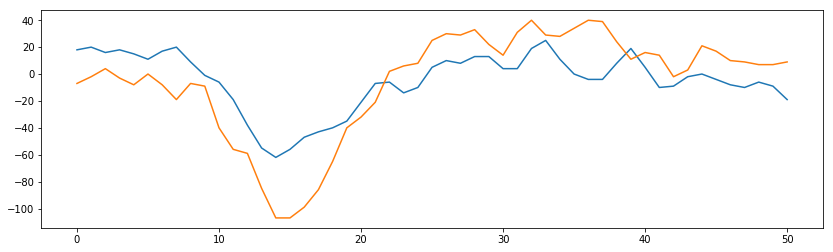

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [9]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [10]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (26260, 51)
Test Datasize: (6566, 51)


# Helper Functions

In [98]:
def find_scaled_mse(original, recons, params):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.var(original[i, :])
        mse.append(np.mean(se))
    print(params, np.median(mse))
    mse = np.array(mse)
    return mse

In [12]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [26]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs):
    fig = plt.figure(1, figsize=(7,5))
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.show()

In [82]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder

In [15]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [16]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])

    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data)
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [17]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        x = np.zeros((batch_size, 51))
        for i, feats in enumerate(selected):
            x[i, :] = input_data[feats, :]
        x = torch.from_numpy(x).float().cuda()
        #---------FORWARD------------#
        enc, out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, x)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])
        if num_epoch%100 == 0:
            print('epoch [{}/{}], loss:{:.8f}, avg:{:.8f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple Shallow

In [18]:
# input -> 50 -> 12 -> emb -> 12 -> 50 -> input

class autoencoder_shallow(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_shallow, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 50),
                                     activation_layer,
                                     nn.Linear(50, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 50),
                                     activation_layer,
                                     nn.Linear(50, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [19]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 100000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_14 = autoencoder_shallow(length, embedding_size).cuda()
ae_14.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_12 = autoencoder_shallow(length, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12 = train_ae(ae_12, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/final_models/losses_1_4', np.array(losses_14))
np.save('models/final_models/losses_1_2', np.array(losses_12))


# Saving Models
torch.save(ae_14, 'models/final_models/ae_1_4.pt') #Saving the autoencoder model
torch.save(ae_12, 'models/final_models/ae_1_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 6575
epoch [1/100000], loss:1591.15026855, avg:1591.15026855
epoch [101/100000], loss:1373.00769043, avg:1400.75390625
epoch [201/100000], loss:903.78472900, avg:937.61505127
epoch [301/100000], loss:416.10717773, avg:432.22470093
epoch [401/100000], loss:252.53994751, avg:256.00717163
epoch [501/100000], loss:204.47033691, avg:208.84037781
epoch [601/100000], loss:180.48773193, avg:181.40979004
epoch [701/100000], loss:161.62823486, avg:161.90745544
epoch [801/100000], loss:162.03004456, avg:155.86735535
epoch [901/100000], loss:146.70132446, avg:147.27804565
epoch [1001/100000], loss:138.59606934, avg:141.92481995
epoch [1101/100000], loss:133.10617065, avg:133.56303406
epoch [1201/100000], loss:121.12763214, avg:128.43946838
epoch [1301/100000], loss:130.77857971, avg:123.68231201
epoch [1401/100000], loss:117.41435242, avg:120.14299774
epoch [1501/100000], loss:128.71170044, avg:118.89393616
epoch [1601/100000], loss:116.17952728, avg:114.83039856
epoch 

epoch [14701/100000], loss:69.24522400, avg:69.50875092
epoch [14801/100000], loss:74.08414459, avg:70.88954163
epoch [14901/100000], loss:69.01775360, avg:70.96147919
epoch [15001/100000], loss:67.63504791, avg:71.64170074
epoch [15101/100000], loss:69.01831055, avg:70.13442993
epoch [15201/100000], loss:70.18730164, avg:70.36213684
epoch [15301/100000], loss:70.61154938, avg:71.55828094
epoch [15401/100000], loss:71.89315033, avg:71.23906708
epoch [15501/100000], loss:65.47644043, avg:71.66014862
epoch [15601/100000], loss:78.95884705, avg:71.38618469
epoch [15701/100000], loss:72.22637939, avg:71.44686127
epoch [15801/100000], loss:69.98519897, avg:71.12166595
epoch [15901/100000], loss:74.17514038, avg:71.54432678
epoch [16001/100000], loss:72.54090881, avg:70.55023956
epoch [16101/100000], loss:73.25266266, avg:70.51809692
epoch [16201/100000], loss:70.64410400, avg:71.18745422
epoch [16301/100000], loss:67.65747070, avg:70.67499542
epoch [16401/100000], loss:69.65327454, avg:69.7

epoch [29401/100000], loss:73.55078125, avg:70.22882843
epoch [29501/100000], loss:72.22973633, avg:70.32254028
epoch [29601/100000], loss:69.63195801, avg:69.14112091
epoch [29701/100000], loss:72.19664001, avg:68.96592712
epoch [29801/100000], loss:69.20763397, avg:69.13632202
epoch [29901/100000], loss:70.69625092, avg:70.70405579
epoch [30001/100000], loss:72.12860107, avg:69.04029846
epoch [30101/100000], loss:71.98087311, avg:69.64311981
epoch [30201/100000], loss:65.61582184, avg:68.93492126
epoch [30301/100000], loss:71.11059570, avg:70.48476410
epoch [30401/100000], loss:71.29617310, avg:69.89286041
epoch [30501/100000], loss:68.91921234, avg:68.18544006
epoch [30601/100000], loss:70.50646973, avg:69.50160980
epoch [30701/100000], loss:68.26243591, avg:69.30407715
epoch [30801/100000], loss:69.61246490, avg:70.22483063
epoch [30901/100000], loss:65.20741272, avg:69.67869568
epoch [31001/100000], loss:70.06733704, avg:69.51586151
epoch [31101/100000], loss:68.79747772, avg:69.2

epoch [44101/100000], loss:75.03095245, avg:68.54394531
epoch [44201/100000], loss:71.29633331, avg:68.45726776
epoch [44301/100000], loss:74.31157684, avg:70.01286316
epoch [44401/100000], loss:68.54021454, avg:70.01323700
epoch [44501/100000], loss:67.66267395, avg:70.90256500
epoch [44601/100000], loss:73.16653442, avg:69.54238129
epoch [44701/100000], loss:67.26140594, avg:69.60024261
epoch [44801/100000], loss:67.42621613, avg:68.75337982
epoch [44901/100000], loss:69.04660797, avg:68.86235046
epoch [45001/100000], loss:70.20555878, avg:70.24587250
epoch [45101/100000], loss:68.61426544, avg:68.92420197
epoch [45201/100000], loss:70.03757477, avg:71.20953369
epoch [45301/100000], loss:65.91429901, avg:69.68566132
epoch [45401/100000], loss:68.82924652, avg:69.67431641
epoch [45501/100000], loss:65.51509094, avg:68.87895966
epoch [45601/100000], loss:73.49617004, avg:70.63418579
epoch [45701/100000], loss:69.26263428, avg:68.85466766
epoch [45801/100000], loss:68.66896057, avg:68.5

epoch [58801/100000], loss:67.89758301, avg:68.72756958
epoch [58901/100000], loss:73.68426514, avg:69.56562042
epoch [59001/100000], loss:66.99794769, avg:68.56704712
epoch [59101/100000], loss:70.83676910, avg:69.22693634
epoch [59201/100000], loss:70.04177094, avg:68.34699249
epoch [59301/100000], loss:68.60237122, avg:68.01180267
epoch [59401/100000], loss:66.74700165, avg:68.10106659
epoch [59501/100000], loss:69.53773499, avg:68.53163147
epoch [59601/100000], loss:68.20563507, avg:68.76866913
epoch [59701/100000], loss:64.26671600, avg:69.19207764
epoch [59801/100000], loss:69.19933319, avg:68.13214111
epoch [59901/100000], loss:64.88988495, avg:68.37740326
epoch [60001/100000], loss:68.32714844, avg:68.63240051
epoch [60101/100000], loss:70.61555481, avg:68.94777679
epoch [60201/100000], loss:71.81577301, avg:68.94708252
epoch [60301/100000], loss:67.55574799, avg:67.81584167
epoch [60401/100000], loss:69.44226074, avg:68.00991821
epoch [60501/100000], loss:68.93933868, avg:69.2

epoch [73501/100000], loss:69.74435425, avg:68.58924866
epoch [73601/100000], loss:68.67837524, avg:69.43110657
epoch [73701/100000], loss:69.94756317, avg:68.65031433
epoch [73801/100000], loss:70.37358856, avg:67.38023376
epoch [73901/100000], loss:67.19406891, avg:67.37614441
epoch [74001/100000], loss:68.38294220, avg:69.09358215
epoch [74101/100000], loss:70.87650299, avg:69.22040558
epoch [74201/100000], loss:69.94848633, avg:68.15180969
epoch [74301/100000], loss:68.77713013, avg:67.65256500
epoch [74401/100000], loss:65.85070038, avg:67.97557068
epoch [74501/100000], loss:74.03346252, avg:70.11928558
epoch [74601/100000], loss:68.63691711, avg:67.54628754
epoch [74701/100000], loss:72.57843018, avg:69.63397217
epoch [74801/100000], loss:67.53156281, avg:69.62629700
epoch [74901/100000], loss:70.32098389, avg:68.06288910
epoch [75001/100000], loss:67.00862885, avg:67.95894623
epoch [75101/100000], loss:65.11994171, avg:68.08605194
epoch [75201/100000], loss:70.27603149, avg:68.0

epoch [88201/100000], loss:72.91426849, avg:68.42039490
epoch [88301/100000], loss:68.06700897, avg:69.57859802
epoch [88401/100000], loss:67.12178040, avg:67.78034210
epoch [88501/100000], loss:67.07344818, avg:67.91816711
epoch [88601/100000], loss:70.23428345, avg:67.94249725
epoch [88701/100000], loss:66.34674835, avg:68.49544525
epoch [88801/100000], loss:66.67057800, avg:68.80083466
epoch [88901/100000], loss:70.49324799, avg:69.34207916
epoch [89001/100000], loss:66.07670593, avg:69.23139954
epoch [89101/100000], loss:66.63576508, avg:68.22359467
epoch [89201/100000], loss:68.56997681, avg:67.94423676
epoch [89301/100000], loss:67.07734680, avg:68.40992737
epoch [89401/100000], loss:66.27687836, avg:69.20576477
epoch [89501/100000], loss:68.91867828, avg:68.04583740
epoch [89601/100000], loss:69.90369415, avg:68.30932617
epoch [89701/100000], loss:69.56735229, avg:67.06922913
epoch [89801/100000], loss:72.38768768, avg:68.57453156
epoch [89901/100000], loss:69.78111267, avg:69.4

epoch [2801/100000], loss:141.66310120, avg:139.40812683
epoch [2901/100000], loss:149.96284485, avg:142.02732849
epoch [3001/100000], loss:137.89764404, avg:136.57420349
epoch [3101/100000], loss:142.17463684, avg:136.41313171
epoch [3201/100000], loss:138.46842957, avg:138.85354614
epoch [3301/100000], loss:135.71582031, avg:137.33775330
epoch [3401/100000], loss:148.14555359, avg:139.26908875
epoch [3501/100000], loss:140.78726196, avg:137.19810486
epoch [3601/100000], loss:142.42535400, avg:138.98416138
epoch [3701/100000], loss:143.88815308, avg:138.07608032
epoch [3801/100000], loss:129.69001770, avg:132.42054749
epoch [3901/100000], loss:124.64391327, avg:135.92247009
epoch [4001/100000], loss:132.93095398, avg:137.02107239
epoch [4101/100000], loss:139.11437988, avg:135.33819580
epoch [4201/100000], loss:135.62760925, avg:139.02311707
epoch [4301/100000], loss:131.02551270, avg:138.94131470
epoch [4401/100000], loss:151.13575745, avg:138.36705017
epoch [4501/100000], loss:142.3

epoch [17101/100000], loss:135.02592468, avg:127.31630707
epoch [17201/100000], loss:125.53909302, avg:126.05310059
epoch [17301/100000], loss:130.24374390, avg:128.99717712
epoch [17401/100000], loss:121.30338287, avg:125.81591797
epoch [17501/100000], loss:118.76671600, avg:126.34112549
epoch [17601/100000], loss:132.93656921, avg:131.28388977
epoch [17701/100000], loss:127.79711151, avg:131.79946899
epoch [17801/100000], loss:122.87398529, avg:128.15513611
epoch [17901/100000], loss:123.07826996, avg:127.39569092
epoch [18001/100000], loss:125.27363586, avg:129.49250793
epoch [18101/100000], loss:138.21038818, avg:131.11437988
epoch [18201/100000], loss:133.95716858, avg:132.70137024
epoch [18301/100000], loss:133.07443237, avg:129.80773926
epoch [18401/100000], loss:137.16549683, avg:130.05981445
epoch [18501/100000], loss:133.54014587, avg:128.76498413
epoch [18601/100000], loss:125.62867737, avg:127.41683197
epoch [18701/100000], loss:125.39067078, avg:128.54406738
epoch [18801/1

epoch [31301/100000], loss:134.79055786, avg:130.00904846
epoch [31401/100000], loss:131.25500488, avg:125.40926361
epoch [31501/100000], loss:124.76743317, avg:127.39701080
epoch [31601/100000], loss:122.70941162, avg:125.02546692
epoch [31701/100000], loss:121.72264099, avg:128.55418396
epoch [31801/100000], loss:133.02583313, avg:125.80415344
epoch [31901/100000], loss:131.18264771, avg:126.16713715
epoch [32001/100000], loss:121.86754608, avg:126.37664795
epoch [32101/100000], loss:130.35235596, avg:126.31874847
epoch [32201/100000], loss:121.96077728, avg:125.47777557
epoch [32301/100000], loss:119.99174500, avg:127.07173157
epoch [32401/100000], loss:136.44703674, avg:129.44511414
epoch [32501/100000], loss:127.94698334, avg:126.42858887
epoch [32601/100000], loss:133.14247131, avg:126.20611572
epoch [32701/100000], loss:136.46569824, avg:131.89062500
epoch [32801/100000], loss:132.81254578, avg:130.91450500
epoch [32901/100000], loss:125.94104767, avg:129.69639587
epoch [33001/1

epoch [45501/100000], loss:118.00487518, avg:123.11296844
epoch [45601/100000], loss:131.30461121, avg:123.81343079
epoch [45701/100000], loss:116.52033234, avg:121.62574768
epoch [45801/100000], loss:127.72573853, avg:121.36661530
epoch [45901/100000], loss:116.55234528, avg:123.54294586
epoch [46001/100000], loss:118.42913055, avg:123.50380707
epoch [46101/100000], loss:119.52236938, avg:121.49983215
epoch [46201/100000], loss:125.10269928, avg:123.68723297
epoch [46301/100000], loss:119.47403717, avg:125.23973846
epoch [46401/100000], loss:127.55854034, avg:121.12463379
epoch [46501/100000], loss:116.85570526, avg:122.69680023
epoch [46601/100000], loss:119.95181274, avg:123.48554993
epoch [46701/100000], loss:126.15817261, avg:123.51612854
epoch [46801/100000], loss:121.78411865, avg:121.53139496
epoch [46901/100000], loss:131.47512817, avg:120.83348846
epoch [47001/100000], loss:114.43341064, avg:122.77204895
epoch [47101/100000], loss:124.50402832, avg:123.50526428
epoch [47201/1

epoch [59701/100000], loss:130.56932068, avg:119.45354462
epoch [59801/100000], loss:119.08697510, avg:118.14973450
epoch [59901/100000], loss:108.25707245, avg:117.62055969
epoch [60001/100000], loss:114.49482727, avg:118.61563873
epoch [60101/100000], loss:122.01326752, avg:118.16426086
epoch [60201/100000], loss:112.40586090, avg:117.31495667
epoch [60301/100000], loss:123.94665527, avg:119.50654602
epoch [60401/100000], loss:127.23034668, avg:119.79515839
epoch [60501/100000], loss:119.19677734, avg:117.82845306
epoch [60601/100000], loss:115.45800781, avg:119.68337250
epoch [60701/100000], loss:113.52198029, avg:117.17180634
epoch [60801/100000], loss:121.58902740, avg:118.65122223
epoch [60901/100000], loss:110.54519653, avg:115.49861908
epoch [61001/100000], loss:117.76960754, avg:119.25595856
epoch [61101/100000], loss:111.15171814, avg:116.23361969
epoch [61201/100000], loss:116.76365662, avg:117.57331848
epoch [61301/100000], loss:117.96694183, avg:118.05432129
epoch [61401/1

epoch [73901/100000], loss:108.84978485, avg:116.46494293
epoch [74001/100000], loss:122.96497345, avg:115.65688324
epoch [74101/100000], loss:120.28823853, avg:117.15466309
epoch [74201/100000], loss:116.29225159, avg:116.43564606
epoch [74301/100000], loss:110.17673492, avg:115.40886688
epoch [74401/100000], loss:117.89412689, avg:115.70656586
epoch [74501/100000], loss:118.41621399, avg:119.55006409
epoch [74601/100000], loss:118.67709351, avg:115.22657776
epoch [74701/100000], loss:119.26185608, avg:116.46260834
epoch [74801/100000], loss:115.17555237, avg:116.30673981
epoch [74901/100000], loss:117.44303131, avg:116.56372070
epoch [75001/100000], loss:113.66157532, avg:113.51955414
epoch [75101/100000], loss:115.93895721, avg:114.20349121
epoch [75201/100000], loss:113.94148254, avg:113.19264984
epoch [75301/100000], loss:115.48876190, avg:115.03631592
epoch [75401/100000], loss:114.23777771, avg:115.52337646
epoch [75501/100000], loss:121.60169220, avg:114.44337463
epoch [75601/1

epoch [88101/100000], loss:111.07058716, avg:112.17087555
epoch [88201/100000], loss:105.89586639, avg:110.44225311
epoch [88301/100000], loss:116.64303589, avg:113.84633636
epoch [88401/100000], loss:106.80715942, avg:113.53277588
epoch [88501/100000], loss:108.47114563, avg:111.09869385
epoch [88601/100000], loss:117.55477142, avg:114.54638672
epoch [88701/100000], loss:114.90650177, avg:111.68254852
epoch [88801/100000], loss:112.77183533, avg:113.24475098
epoch [88901/100000], loss:120.20323181, avg:115.25658417
epoch [89001/100000], loss:111.41019440, avg:115.99300385
epoch [89101/100000], loss:123.22525024, avg:116.51548004
epoch [89201/100000], loss:115.05937195, avg:112.19591522
epoch [89301/100000], loss:117.28503418, avg:113.11008453
epoch [89401/100000], loss:116.75609589, avg:115.23543549
epoch [89501/100000], loss:108.56883240, avg:114.23884583
epoch [89601/100000], loss:109.33094788, avg:111.79699707
epoch [89701/100000], loss:117.77175140, avg:116.00389862
epoch [89801/1

In [59]:
ae_1 = torch.load('models/final_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/final_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.9556633906233072
PCA 0.9483949747235514


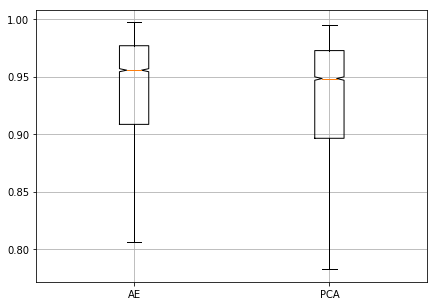

In [60]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2165439846408077
AE 2.984994437788032


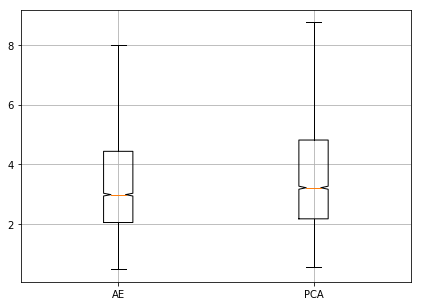

In [61]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Simple Deep

In [42]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_deep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_deep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 50),
                                     activation_layer,
                                     nn.Linear(50, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [43]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 100000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_44 = autoencoder_deep(length, embedding_size).cuda()
ae_44.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_42 = autoencoder_deep(length, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42 = train_ae(ae_42, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/final_models/losses_4_4', np.array(losses_44))
np.save('models/final_models/losses_4_2', np.array(losses_42))


# Saving Models
torch.save(ae_44, 'models/final_models/ae_4_4.pt') #Saving the autoencoder model
torch.save(ae_42, 'models/final_models/ae_4_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 23825
epoch [1/100000], loss:1691.02636719, avg:1691.02636719
epoch [101/100000], loss:1311.70898438, avg:1343.42492676
epoch [201/100000], loss:386.12463379, avg:398.94625854
epoch [301/100000], loss:221.50158691, avg:222.21891785
epoch [401/100000], loss:181.16757202, avg:177.86897278
epoch [501/100000], loss:155.25878906, avg:151.99247742
epoch [601/100000], loss:142.43061829, avg:149.18696594
epoch [701/100000], loss:147.50912476, avg:136.69703674
epoch [801/100000], loss:117.61187744, avg:121.42324066
epoch [901/100000], loss:114.52693176, avg:120.35162354
epoch [1001/100000], loss:115.62397766, avg:113.60003662
epoch [1101/100000], loss:114.40014648, avg:112.40559387
epoch [1201/100000], loss:102.28054047, avg:107.71884918
epoch [1301/100000], loss:108.10249329, avg:105.51759338
epoch [1401/100000], loss:100.55999756, avg:107.82082367
epoch [1501/100000], loss:102.67313385, avg:106.59087372
epoch [1601/100000], loss:120.57516479, avg:107.28018951
epoch

epoch [14701/100000], loss:66.25623322, avg:70.92400360
epoch [14801/100000], loss:70.54969788, avg:70.29630280
epoch [14901/100000], loss:67.41726685, avg:68.86510468
epoch [15001/100000], loss:72.00334930, avg:70.89654541
epoch [15101/100000], loss:68.37528992, avg:71.42035675
epoch [15201/100000], loss:66.85781860, avg:70.64794159
epoch [15301/100000], loss:71.83920288, avg:71.15865326
epoch [15401/100000], loss:70.47525787, avg:70.21331024
epoch [15501/100000], loss:73.30972290, avg:71.04280090
epoch [15601/100000], loss:69.50444794, avg:70.23305511
epoch [15701/100000], loss:73.53022766, avg:71.64611053
epoch [15801/100000], loss:70.41007996, avg:70.17424774
epoch [15901/100000], loss:67.38137817, avg:70.05614471
epoch [16001/100000], loss:69.53578186, avg:70.69405365
epoch [16101/100000], loss:69.46234131, avg:69.15701294
epoch [16201/100000], loss:73.44203186, avg:71.42314911
epoch [16301/100000], loss:69.74568939, avg:70.79850769
epoch [16401/100000], loss:70.00892639, avg:70.8

epoch [29401/100000], loss:68.22323608, avg:67.79038239
epoch [29501/100000], loss:67.21507263, avg:68.49974823
epoch [29601/100000], loss:66.50342560, avg:68.40770721
epoch [29701/100000], loss:67.38731384, avg:68.24051666
epoch [29801/100000], loss:64.97534943, avg:69.14266205
epoch [29901/100000], loss:68.31322479, avg:67.73974609
epoch [30001/100000], loss:68.75137329, avg:67.43943024
epoch [30101/100000], loss:68.31690979, avg:68.00682831
epoch [30201/100000], loss:67.73673248, avg:69.57464600
epoch [30301/100000], loss:66.60487366, avg:68.22869110
epoch [30401/100000], loss:66.87648773, avg:67.07087708
epoch [30501/100000], loss:66.96311188, avg:68.52266693
epoch [30601/100000], loss:70.48442841, avg:67.44918823
epoch [30701/100000], loss:68.51591492, avg:68.81264496
epoch [30801/100000], loss:66.71305847, avg:67.72536469
epoch [30901/100000], loss:66.51239014, avg:68.30715179
epoch [31001/100000], loss:66.61362457, avg:68.83537292
epoch [31101/100000], loss:66.25216675, avg:68.0

epoch [44101/100000], loss:67.24707031, avg:66.20555878
epoch [44201/100000], loss:65.30074310, avg:66.27067566
epoch [44301/100000], loss:62.53445435, avg:66.05272675
epoch [44401/100000], loss:65.07801819, avg:66.65901947
epoch [44501/100000], loss:65.24965668, avg:66.23786926
epoch [44601/100000], loss:68.26062775, avg:66.60115051
epoch [44701/100000], loss:64.64378357, avg:66.37210083
epoch [44801/100000], loss:66.50946808, avg:65.91603851
epoch [44901/100000], loss:67.68674469, avg:67.06469727
epoch [45001/100000], loss:64.33374023, avg:66.33231354
epoch [45101/100000], loss:65.85497284, avg:65.89374542
epoch [45201/100000], loss:67.03424072, avg:65.74954987
epoch [45301/100000], loss:66.35565186, avg:66.27202606
epoch [45401/100000], loss:65.30714417, avg:66.55234528
epoch [45501/100000], loss:63.37250900, avg:66.11186981
epoch [45601/100000], loss:64.14038849, avg:67.30139160
epoch [45701/100000], loss:64.68574524, avg:66.36785126
epoch [45801/100000], loss:63.93364334, avg:66.6

epoch [58801/100000], loss:63.65861893, avg:64.43524170
epoch [58901/100000], loss:67.31156158, avg:65.97663116
epoch [59001/100000], loss:64.08774567, avg:65.15164948
epoch [59101/100000], loss:63.27367783, avg:63.49908066
epoch [59201/100000], loss:62.22743607, avg:64.45092010
epoch [59301/100000], loss:66.24697876, avg:64.91716766
epoch [59401/100000], loss:67.21700287, avg:64.60032654
epoch [59501/100000], loss:62.83541107, avg:64.71834564
epoch [59601/100000], loss:64.56978607, avg:64.72025299
epoch [59701/100000], loss:62.92268372, avg:64.44807434
epoch [59801/100000], loss:65.09712219, avg:64.77923584
epoch [59901/100000], loss:64.33603668, avg:64.63658905
epoch [60001/100000], loss:64.92650604, avg:64.52870941
epoch [60101/100000], loss:63.37977982, avg:63.17385483
epoch [60201/100000], loss:65.65716553, avg:64.16567230
epoch [60301/100000], loss:63.41693497, avg:64.55995941
epoch [60401/100000], loss:62.62804794, avg:64.47229767
epoch [60501/100000], loss:62.98911667, avg:63.9

epoch [73501/100000], loss:64.02374268, avg:63.18512726
epoch [73601/100000], loss:65.79788208, avg:63.47830963
epoch [73701/100000], loss:62.63311005, avg:62.20178986
epoch [73801/100000], loss:63.57080841, avg:63.06746292
epoch [73901/100000], loss:63.72970581, avg:62.85390854
epoch [74001/100000], loss:62.86000443, avg:64.10385895
epoch [74101/100000], loss:67.07200623, avg:64.72441101
epoch [74201/100000], loss:63.60025406, avg:63.58595657
epoch [74301/100000], loss:60.79679108, avg:63.93241119
epoch [74401/100000], loss:64.72891235, avg:63.34099197
epoch [74501/100000], loss:65.14617157, avg:64.75981903
epoch [74601/100000], loss:65.26869965, avg:63.39353180
epoch [74701/100000], loss:66.59547424, avg:63.55488205
epoch [74801/100000], loss:66.79689789, avg:63.36022949
epoch [74901/100000], loss:64.86747742, avg:63.18249512
epoch [75001/100000], loss:62.28106308, avg:63.13431549
epoch [75101/100000], loss:64.81995392, avg:64.68097687
epoch [75201/100000], loss:67.15661621, avg:64.1

epoch [88201/100000], loss:62.44356155, avg:62.95658493
epoch [88301/100000], loss:63.13103867, avg:62.42828369
epoch [88401/100000], loss:62.35610580, avg:62.39829254
epoch [88501/100000], loss:62.54365158, avg:62.76919174
epoch [88601/100000], loss:62.38803101, avg:62.92095947
epoch [88701/100000], loss:62.79625702, avg:62.56205368
epoch [88801/100000], loss:61.83061981, avg:62.55301666
epoch [88901/100000], loss:59.44123459, avg:62.24948883
epoch [89001/100000], loss:61.27879715, avg:63.18626785
epoch [89101/100000], loss:62.61178970, avg:62.63201904
epoch [89201/100000], loss:63.17326736, avg:62.57339096
epoch [89301/100000], loss:61.17330170, avg:62.42959595
epoch [89401/100000], loss:66.58646393, avg:62.75466919
epoch [89501/100000], loss:62.59812164, avg:61.99596024
epoch [89601/100000], loss:61.43186951, avg:61.97727203
epoch [89701/100000], loss:61.98415375, avg:63.07594681
epoch [89801/100000], loss:64.47137451, avg:63.18972397
epoch [89901/100000], loss:62.85910034, avg:62.5

epoch [2801/100000], loss:126.01717377, avg:132.75936890
epoch [2901/100000], loss:126.45977783, avg:130.88108826
epoch [3001/100000], loss:130.09318542, avg:134.15792847
epoch [3101/100000], loss:129.62265015, avg:130.20434570
epoch [3201/100000], loss:138.45527649, avg:134.76530457
epoch [3301/100000], loss:132.91094971, avg:128.97972107
epoch [3401/100000], loss:132.04908752, avg:132.58049011
epoch [3501/100000], loss:130.01232910, avg:129.84442139
epoch [3601/100000], loss:132.80918884, avg:129.58210754
epoch [3701/100000], loss:123.58203888, avg:128.90194702
epoch [3801/100000], loss:132.64065552, avg:128.26560974
epoch [3901/100000], loss:125.37664795, avg:129.79341125
epoch [4001/100000], loss:126.01495361, avg:129.39860535
epoch [4101/100000], loss:130.26605225, avg:132.86120605
epoch [4201/100000], loss:122.07591248, avg:129.07583618
epoch [4301/100000], loss:126.27179718, avg:128.26339722
epoch [4401/100000], loss:126.09432983, avg:131.33238220
epoch [4501/100000], loss:132.5

epoch [17101/100000], loss:139.03669739, avg:128.13366699
epoch [17201/100000], loss:125.43183136, avg:127.06996918
epoch [17301/100000], loss:127.19988251, avg:126.75819397
epoch [17401/100000], loss:132.22412109, avg:127.66687012
epoch [17501/100000], loss:135.48364258, avg:129.71463013
epoch [17601/100000], loss:126.34931183, avg:129.75895691
epoch [17701/100000], loss:122.79881287, avg:128.59780884
epoch [17801/100000], loss:121.97416687, avg:128.41642761
epoch [17901/100000], loss:132.17247009, avg:129.50474548
epoch [18001/100000], loss:124.51044464, avg:129.30717468
epoch [18101/100000], loss:122.30361176, avg:129.00686646
epoch [18201/100000], loss:126.32289124, avg:127.74117279
epoch [18301/100000], loss:139.80049133, avg:133.00794983
epoch [18401/100000], loss:120.94082642, avg:130.56617737
epoch [18501/100000], loss:130.34516907, avg:130.35681152
epoch [18601/100000], loss:123.90301514, avg:127.28547668
epoch [18701/100000], loss:138.70526123, avg:127.88032532
epoch [18801/1

epoch [31301/100000], loss:116.23416901, avg:127.66722870
epoch [31401/100000], loss:129.08747864, avg:127.14129639
epoch [31501/100000], loss:123.55338287, avg:128.54734802
epoch [31601/100000], loss:130.91381836, avg:127.50189209
epoch [31701/100000], loss:125.03011322, avg:128.05210876
epoch [31801/100000], loss:130.95320129, avg:129.07603455
epoch [31901/100000], loss:141.22709656, avg:131.87965393
epoch [32001/100000], loss:128.35421753, avg:127.82806396
epoch [32101/100000], loss:126.01046753, avg:126.60774994
epoch [32201/100000], loss:122.41641998, avg:128.55094910
epoch [32301/100000], loss:119.06222534, avg:132.78515625
epoch [32401/100000], loss:130.88935852, avg:129.65290833
epoch [32501/100000], loss:124.16230011, avg:125.58766937
epoch [32601/100000], loss:128.31242371, avg:127.11240387
epoch [32701/100000], loss:132.95617676, avg:128.21562195
epoch [32801/100000], loss:130.40757751, avg:127.88172913
epoch [32901/100000], loss:128.20019531, avg:127.78309631
epoch [33001/1

epoch [45501/100000], loss:106.01186371, avg:116.44891357
epoch [45601/100000], loss:105.14447021, avg:117.46228027
epoch [45701/100000], loss:115.76192474, avg:115.40506744
epoch [45801/100000], loss:124.22181702, avg:118.81683350
epoch [45901/100000], loss:116.79323578, avg:117.88838959
epoch [46001/100000], loss:116.24295807, avg:118.61928558
epoch [46101/100000], loss:118.06359100, avg:119.55187988
epoch [46201/100000], loss:116.20298767, avg:118.14178467
epoch [46301/100000], loss:110.53413391, avg:115.80852509
epoch [46401/100000], loss:112.66696930, avg:116.24149323
epoch [46501/100000], loss:117.44082642, avg:119.87152100
epoch [46601/100000], loss:110.95545959, avg:121.11016083
epoch [46701/100000], loss:120.34722900, avg:118.13476562
epoch [46801/100000], loss:119.43984985, avg:119.03447723
epoch [46901/100000], loss:115.01277924, avg:119.56755829
epoch [47001/100000], loss:125.96416473, avg:117.28311920
epoch [47101/100000], loss:122.41942596, avg:116.20359039
epoch [47201/1

epoch [59701/100000], loss:108.51744080, avg:112.45100403
epoch [59801/100000], loss:108.27285767, avg:113.21044159
epoch [59901/100000], loss:115.07656860, avg:114.25746918
epoch [60001/100000], loss:120.28289032, avg:113.64232635
epoch [60101/100000], loss:117.60776520, avg:115.75811768
epoch [60201/100000], loss:106.79965973, avg:114.55789948
epoch [60301/100000], loss:111.92433167, avg:112.83489227
epoch [60401/100000], loss:120.92875671, avg:113.85062408
epoch [60501/100000], loss:107.37126160, avg:114.70820618
epoch [60601/100000], loss:117.11632538, avg:115.34126282
epoch [60701/100000], loss:113.10204315, avg:114.53215790
epoch [60801/100000], loss:108.69342804, avg:113.79237366
epoch [60901/100000], loss:117.75594330, avg:114.66591644
epoch [61001/100000], loss:112.02593994, avg:114.92876434
epoch [61101/100000], loss:114.53357697, avg:114.28503418
epoch [61201/100000], loss:111.35112000, avg:114.66162109
epoch [61301/100000], loss:109.74092865, avg:112.89845276
epoch [61401/1

epoch [73901/100000], loss:116.44879150, avg:112.03879547
epoch [74001/100000], loss:115.37950897, avg:112.07849121
epoch [74101/100000], loss:114.08866119, avg:110.56874847
epoch [74201/100000], loss:116.53823853, avg:111.35951233
epoch [74301/100000], loss:111.76042175, avg:110.17366028
epoch [74401/100000], loss:110.73493958, avg:109.02188873
epoch [74501/100000], loss:113.17771149, avg:109.78427887
epoch [74601/100000], loss:113.14834595, avg:109.80537415
epoch [74701/100000], loss:107.85712433, avg:110.02709961
epoch [74801/100000], loss:106.74782562, avg:110.08546448
epoch [74901/100000], loss:108.73441315, avg:111.36934662
epoch [75001/100000], loss:112.12387085, avg:109.96838379
epoch [75101/100000], loss:115.36872864, avg:111.38149261
epoch [75201/100000], loss:112.66839600, avg:110.31579590
epoch [75301/100000], loss:113.26212311, avg:109.55226898
epoch [75401/100000], loss:107.71317291, avg:109.69148254
epoch [75501/100000], loss:106.49646759, avg:110.94294739
epoch [75601/1

epoch [88101/100000], loss:109.20320892, avg:108.29200745
epoch [88201/100000], loss:103.58001709, avg:106.38796234
epoch [88301/100000], loss:111.86083221, avg:109.13453674
epoch [88401/100000], loss:107.31594849, avg:108.81794739
epoch [88501/100000], loss:108.25299072, avg:109.58436584
epoch [88601/100000], loss:108.30287933, avg:107.67087555
epoch [88701/100000], loss:109.16522980, avg:108.89122772
epoch [88801/100000], loss:103.03385162, avg:109.38130951
epoch [88901/100000], loss:105.77040863, avg:108.23121643
epoch [89001/100000], loss:105.78726959, avg:106.57181549
epoch [89101/100000], loss:109.24931335, avg:109.54398346
epoch [89201/100000], loss:109.73148346, avg:108.59039307
epoch [89301/100000], loss:108.11605835, avg:107.01716614
epoch [89401/100000], loss:109.50286102, avg:108.76290131
epoch [89501/100000], loss:108.16854858, avg:107.63146210
epoch [89601/100000], loss:101.08943176, avg:108.34200287
epoch [89701/100000], loss:109.89565277, avg:107.72290039
epoch [89801/1

In [62]:
ae_1 = torch.load('models/final_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/final_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.9593285893420154
PCA 0.9483949747235507


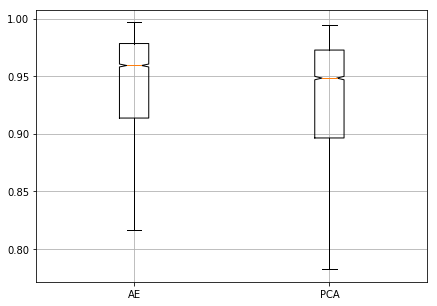

In [63]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2165439846404635
AE 2.8837403183854446


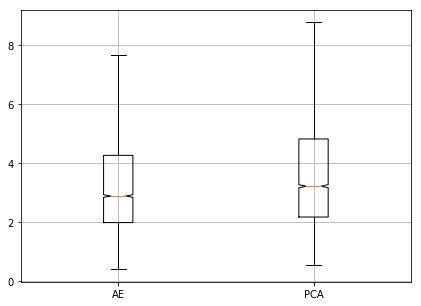

In [64]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Deep Encoder - Shallow Decoder Variation

In [47]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_var(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_var, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 80),
                                     activation_layer,
                                     nn.Linear(80, 40),
                                     activation_layer,
                                     nn.Linear(40, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 10),
                                     activation_layer,
                                     nn.Linear(10, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [48]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 100000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_54 = autoencoder_var(length, embedding_size).cuda()
ae_54.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_var(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52 = train_ae(ae_52, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/final_models/losses_5_4', np.array(losses_54))
np.save('models/final_models/losses_5_2', np.array(losses_52))


# Saving Models
torch.save(ae_54, 'models/final_models/ae_5_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/final_models/ae_5_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 15555
epoch [1/100000], loss:1655.43859863, avg:1655.43859863
epoch [101/100000], loss:1484.34423828, avg:1476.20886230
epoch [201/100000], loss:421.84649658, avg:442.59140015
epoch [301/100000], loss:246.16142273, avg:249.50199890
epoch [401/100000], loss:233.79722595, avg:240.75244141
epoch [501/100000], loss:233.88679504, avg:235.99467468
epoch [601/100000], loss:190.94335938, avg:204.10731506
epoch [701/100000], loss:162.49183655, avg:168.17730713
epoch [801/100000], loss:144.71925354, avg:151.82373047
epoch [901/100000], loss:144.84843445, avg:147.68762207
epoch [1001/100000], loss:151.86257935, avg:148.85578918
epoch [1101/100000], loss:140.94703674, avg:144.99668884
epoch [1201/100000], loss:150.60284424, avg:141.91386414
epoch [1301/100000], loss:139.93937683, avg:144.48829651
epoch [1401/100000], loss:159.75234985, avg:147.47286987
epoch [1501/100000], loss:136.93760681, avg:145.41459656
epoch [1601/100000], loss:144.68249512, avg:143.55436707
epoch

epoch [14701/100000], loss:74.19281006, avg:70.88828278
epoch [14801/100000], loss:73.33399200, avg:71.69005585
epoch [14901/100000], loss:75.90344238, avg:71.71401215
epoch [15001/100000], loss:68.54124451, avg:71.90550995
epoch [15101/100000], loss:71.95045471, avg:70.76951599
epoch [15201/100000], loss:70.13921356, avg:72.47461700
epoch [15301/100000], loss:72.50705719, avg:71.60044098
epoch [15401/100000], loss:69.09870911, avg:70.35307312
epoch [15501/100000], loss:73.35925293, avg:70.33518219
epoch [15601/100000], loss:72.72869110, avg:72.26776886
epoch [15701/100000], loss:69.32035065, avg:71.00956726
epoch [15801/100000], loss:68.48247528, avg:69.89435577
epoch [15901/100000], loss:74.10622406, avg:72.63202667
epoch [16001/100000], loss:75.47896576, avg:72.81352234
epoch [16101/100000], loss:65.75354767, avg:70.59251404
epoch [16201/100000], loss:72.07923889, avg:71.90415192
epoch [16301/100000], loss:70.71266937, avg:70.72732544
epoch [16401/100000], loss:68.92389679, avg:70.3

epoch [29401/100000], loss:66.21160126, avg:69.14156342
epoch [29501/100000], loss:73.07365417, avg:69.29208374
epoch [29601/100000], loss:68.61528778, avg:68.43593597
epoch [29701/100000], loss:67.97073364, avg:69.18843842
epoch [29801/100000], loss:69.83879089, avg:68.95268250
epoch [29901/100000], loss:67.74494171, avg:69.13059235
epoch [30001/100000], loss:67.42699432, avg:68.59327698
epoch [30101/100000], loss:68.89782715, avg:68.72943115
epoch [30201/100000], loss:68.06272125, avg:70.01645660
epoch [30301/100000], loss:68.25521851, avg:69.12889862
epoch [30401/100000], loss:70.19248962, avg:68.61388397
epoch [30501/100000], loss:67.27509308, avg:69.23444366
epoch [30601/100000], loss:65.25918579, avg:69.02243805
epoch [30701/100000], loss:68.36468506, avg:70.38777924
epoch [30801/100000], loss:67.53138733, avg:68.47801971
epoch [30901/100000], loss:69.26403809, avg:68.78458405
epoch [31001/100000], loss:67.71175385, avg:69.23397064
epoch [31101/100000], loss:67.88334656, avg:69.0

epoch [44101/100000], loss:64.88648987, avg:67.64843750
epoch [44201/100000], loss:69.20141602, avg:67.12705231
epoch [44301/100000], loss:69.65798187, avg:68.34732056
epoch [44401/100000], loss:66.16340637, avg:67.72501373
epoch [44501/100000], loss:65.60933685, avg:66.47615051
epoch [44601/100000], loss:62.64553070, avg:67.43657684
epoch [44701/100000], loss:70.76445770, avg:66.00431061
epoch [44801/100000], loss:66.87958527, avg:67.51656342
epoch [44901/100000], loss:65.72650909, avg:66.56490326
epoch [45001/100000], loss:66.21528625, avg:66.44037628
epoch [45101/100000], loss:67.18020630, avg:67.03481293
epoch [45201/100000], loss:69.93614197, avg:67.03771210
epoch [45301/100000], loss:68.63144684, avg:66.21847534
epoch [45401/100000], loss:68.63408661, avg:67.98984528
epoch [45501/100000], loss:71.78774261, avg:67.30496979
epoch [45601/100000], loss:67.74642944, avg:66.39943695
epoch [45701/100000], loss:66.28543091, avg:64.98430634
epoch [45801/100000], loss:66.75569153, avg:67.0

epoch [58801/100000], loss:65.61407471, avg:65.13916779
epoch [58901/100000], loss:64.20662689, avg:65.21601105
epoch [59001/100000], loss:63.85026169, avg:66.27426147
epoch [59101/100000], loss:66.51494598, avg:66.25631714
epoch [59201/100000], loss:67.74967194, avg:66.29382324
epoch [59301/100000], loss:66.23759460, avg:65.48341370
epoch [59401/100000], loss:66.32130432, avg:65.83480072
epoch [59501/100000], loss:66.02256775, avg:65.79530334
epoch [59601/100000], loss:63.76866150, avg:65.56970215
epoch [59701/100000], loss:65.26055908, avg:66.04418182
epoch [59801/100000], loss:64.71529388, avg:65.50621796
epoch [59901/100000], loss:65.96929932, avg:66.11128998
epoch [60001/100000], loss:68.88143158, avg:66.84404755
epoch [60101/100000], loss:64.13714600, avg:64.59901428
epoch [60201/100000], loss:64.32150269, avg:65.58680725
epoch [60301/100000], loss:63.46354675, avg:64.31068420
epoch [60401/100000], loss:65.41093445, avg:66.41429901
epoch [60501/100000], loss:66.07647705, avg:65.3

epoch [73501/100000], loss:65.37239838, avg:64.33556366
epoch [73601/100000], loss:62.49330902, avg:63.98505402
epoch [73701/100000], loss:64.90288544, avg:64.23427582
epoch [73801/100000], loss:61.73404694, avg:64.63787842
epoch [73901/100000], loss:68.24814606, avg:64.51190948
epoch [74001/100000], loss:66.06184387, avg:65.56320190
epoch [74101/100000], loss:65.28343201, avg:64.43852997
epoch [74201/100000], loss:62.31109619, avg:64.14857483
epoch [74301/100000], loss:62.99518967, avg:64.64915466
epoch [74401/100000], loss:64.83505249, avg:64.80074310
epoch [74501/100000], loss:65.86953735, avg:65.55310059
epoch [74601/100000], loss:66.26649475, avg:65.43109894
epoch [74701/100000], loss:65.17453003, avg:64.72241211
epoch [74801/100000], loss:65.60773468, avg:64.10234833
epoch [74901/100000], loss:65.94666290, avg:65.13787842
epoch [75001/100000], loss:63.76651001, avg:65.05718231
epoch [75101/100000], loss:62.57899475, avg:64.24615479
epoch [75201/100000], loss:63.55822372, avg:63.6

epoch [88201/100000], loss:65.41417694, avg:64.91439056
epoch [88301/100000], loss:61.32601166, avg:63.45202637
epoch [88401/100000], loss:64.71921539, avg:64.26406860
epoch [88501/100000], loss:68.90568542, avg:64.08191681
epoch [88601/100000], loss:66.86646271, avg:65.05617523
epoch [88701/100000], loss:62.84298325, avg:64.56898499
epoch [88801/100000], loss:62.99040604, avg:64.56668091
epoch [88901/100000], loss:64.95324707, avg:64.06938934
epoch [89001/100000], loss:63.65277863, avg:64.61695099
epoch [89101/100000], loss:67.82595062, avg:64.63356018
epoch [89201/100000], loss:63.25484085, avg:64.32096100
epoch [89301/100000], loss:62.41911697, avg:64.30474091
epoch [89401/100000], loss:64.64953613, avg:64.69917297
epoch [89501/100000], loss:61.85095596, avg:65.25859833
epoch [89601/100000], loss:61.88945389, avg:64.77903748
epoch [89701/100000], loss:64.34009552, avg:64.34734344
epoch [89801/100000], loss:63.69010544, avg:64.85839081
epoch [89901/100000], loss:61.70810318, avg:62.4

epoch [2801/100000], loss:128.51928711, avg:137.86227417
epoch [2901/100000], loss:131.45533752, avg:139.70617676
epoch [3001/100000], loss:141.75271606, avg:136.98869324
epoch [3101/100000], loss:143.00294495, avg:137.70767212
epoch [3201/100000], loss:141.60949707, avg:137.04273987
epoch [3301/100000], loss:136.18225098, avg:137.00169373
epoch [3401/100000], loss:125.49771118, avg:139.35336304
epoch [3501/100000], loss:139.22985840, avg:136.81517029
epoch [3601/100000], loss:139.38160706, avg:138.87452698
epoch [3701/100000], loss:137.10398865, avg:136.45170593
epoch [3801/100000], loss:148.91596985, avg:139.28469849
epoch [3901/100000], loss:137.84553528, avg:140.00668335
epoch [4001/100000], loss:138.82054138, avg:140.95576477
epoch [4101/100000], loss:132.47991943, avg:136.31582642
epoch [4201/100000], loss:139.46951294, avg:136.37145996
epoch [4301/100000], loss:139.72993469, avg:137.02900696
epoch [4401/100000], loss:128.88189697, avg:138.15361023
epoch [4501/100000], loss:131.6

epoch [17101/100000], loss:128.34114075, avg:122.33446503
epoch [17201/100000], loss:117.37205505, avg:125.41664886
epoch [17301/100000], loss:128.36576843, avg:124.63140869
epoch [17401/100000], loss:131.39596558, avg:122.11734772
epoch [17501/100000], loss:128.05285645, avg:124.57061005
epoch [17601/100000], loss:127.90000153, avg:126.56117249
epoch [17701/100000], loss:121.45141602, avg:124.17604828
epoch [17801/100000], loss:126.26715851, avg:119.04376221
epoch [17901/100000], loss:120.90602112, avg:124.71355438
epoch [18001/100000], loss:116.31566620, avg:121.15746307
epoch [18101/100000], loss:119.45896912, avg:120.89247894
epoch [18201/100000], loss:119.60284424, avg:123.13342285
epoch [18301/100000], loss:120.40063477, avg:123.65107727
epoch [18401/100000], loss:122.62516022, avg:121.17041016
epoch [18501/100000], loss:122.29973602, avg:119.96929932
epoch [18601/100000], loss:108.79573822, avg:120.57736969
epoch [18701/100000], loss:123.99678802, avg:123.26319885
epoch [18801/1

epoch [31301/100000], loss:110.09355164, avg:110.68556976
epoch [31401/100000], loss:114.87599945, avg:113.42905426
epoch [31501/100000], loss:114.70803833, avg:114.72885895
epoch [31601/100000], loss:104.62960815, avg:113.71263885
epoch [31701/100000], loss:120.03870392, avg:113.28747559
epoch [31801/100000], loss:122.22167969, avg:112.81082916
epoch [31901/100000], loss:112.86343384, avg:115.37849426
epoch [32001/100000], loss:118.98819733, avg:112.85359192
epoch [32101/100000], loss:117.24585724, avg:116.53853607
epoch [32201/100000], loss:116.94780731, avg:116.36766815
epoch [32301/100000], loss:111.69051361, avg:113.33274078
epoch [32401/100000], loss:124.42300415, avg:115.65209198
epoch [32501/100000], loss:110.68138123, avg:114.77848053
epoch [32601/100000], loss:121.34248352, avg:116.35546112
epoch [32701/100000], loss:103.59050751, avg:114.76374817
epoch [32801/100000], loss:108.70256805, avg:117.20942688
epoch [32901/100000], loss:109.35382080, avg:114.96296692
epoch [33001/1

epoch [45501/100000], loss:106.70983887, avg:109.60876465
epoch [45601/100000], loss:103.41908264, avg:109.34877014
epoch [45701/100000], loss:104.52333069, avg:108.98646545
epoch [45801/100000], loss:116.27239227, avg:113.04322815
epoch [45901/100000], loss:115.59803772, avg:109.46063232
epoch [46001/100000], loss:114.98619843, avg:110.36956787
epoch [46101/100000], loss:108.52079773, avg:108.77246094
epoch [46201/100000], loss:114.24377441, avg:110.71125793
epoch [46301/100000], loss:107.88053894, avg:110.16145325
epoch [46401/100000], loss:109.96655273, avg:110.26977539
epoch [46501/100000], loss:118.17167664, avg:107.04587555
epoch [46601/100000], loss:108.50212860, avg:109.64003754
epoch [46701/100000], loss:114.96884155, avg:109.95532227
epoch [46801/100000], loss:107.29601288, avg:108.16301727
epoch [46901/100000], loss:111.62362671, avg:109.87371063
epoch [47001/100000], loss:113.05543518, avg:109.61457825
epoch [47101/100000], loss:108.57000732, avg:109.41987610
epoch [47201/1

epoch [59701/100000], loss:117.85225677, avg:108.68895721
epoch [59801/100000], loss:109.03588104, avg:108.99487305
epoch [59901/100000], loss:107.74636078, avg:107.82547760
epoch [60001/100000], loss:103.73583984, avg:109.14873505
epoch [60101/100000], loss:106.21655273, avg:109.19487762
epoch [60201/100000], loss:111.87923431, avg:107.96158600
epoch [60301/100000], loss:108.54047394, avg:105.46915436
epoch [60401/100000], loss:111.67028046, avg:109.77664948
epoch [60501/100000], loss:102.16452026, avg:106.36483002
epoch [60601/100000], loss:115.19705963, avg:109.92118073
epoch [60701/100000], loss:105.95568848, avg:110.28194427
epoch [60801/100000], loss:110.85555267, avg:111.02545166
epoch [60901/100000], loss:104.29270935, avg:107.72330475
epoch [61001/100000], loss:107.59452820, avg:107.74182129
epoch [61101/100000], loss:106.72783661, avg:108.69930267
epoch [61201/100000], loss:107.46160126, avg:108.26043701
epoch [61301/100000], loss:103.50613403, avg:107.89524078
epoch [61401/1

epoch [73901/100000], loss:111.92930603, avg:107.25955963
epoch [74001/100000], loss:104.77043915, avg:107.31443024
epoch [74101/100000], loss:111.50563812, avg:105.27626801
epoch [74201/100000], loss:108.10264587, avg:106.78804016
epoch [74301/100000], loss:102.04611206, avg:107.86291504
epoch [74401/100000], loss:109.38950348, avg:107.50223541
epoch [74501/100000], loss:113.49581909, avg:110.03054047
epoch [74601/100000], loss:103.17420197, avg:108.31164551
epoch [74701/100000], loss:111.22971344, avg:110.18737030
epoch [74801/100000], loss:106.43197632, avg:106.35958099
epoch [74901/100000], loss:107.66185760, avg:108.27327728
epoch [75001/100000], loss:109.44795990, avg:107.81784821
epoch [75101/100000], loss:104.85091400, avg:106.42813873
epoch [75201/100000], loss:104.49009705, avg:107.29222870
epoch [75301/100000], loss:114.09016418, avg:110.44044495
epoch [75401/100000], loss:111.46900940, avg:109.27658844
epoch [75501/100000], loss:114.33542633, avg:110.19425201
epoch [75601/1

epoch [88101/100000], loss:105.03466034, avg:107.90551758
epoch [88201/100000], loss:110.46556854, avg:110.51988983
epoch [88301/100000], loss:102.62171936, avg:107.45717621
epoch [88401/100000], loss:113.68946838, avg:107.70670319
epoch [88501/100000], loss:114.07933807, avg:110.02446747
epoch [88601/100000], loss:105.42903900, avg:106.30504608
epoch [88701/100000], loss:105.26222992, avg:109.01094055
epoch [88801/100000], loss:101.76621246, avg:107.76930237
epoch [88901/100000], loss:107.97409821, avg:106.19582367
epoch [89001/100000], loss:103.98589325, avg:108.81111908
epoch [89101/100000], loss:108.57465363, avg:107.13356781
epoch [89201/100000], loss:109.03057098, avg:109.66407776
epoch [89301/100000], loss:111.62730408, avg:108.49959564
epoch [89401/100000], loss:111.92342377, avg:109.40134430
epoch [89501/100000], loss:109.95514679, avg:110.21355438
epoch [89601/100000], loss:104.39481354, avg:106.86468506
epoch [89701/100000], loss:109.78002930, avg:109.87534332
epoch [89801/1

In [65]:
ae_1 = torch.load('models/final_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/final_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

AE 0.9570709965828998
PCA 0.9483949747235509


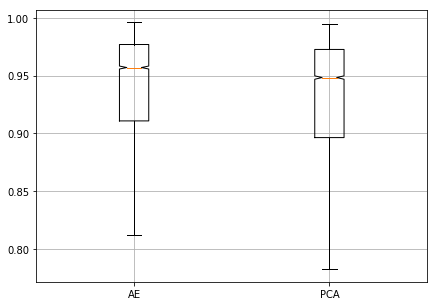

In [66]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.216543984640378
AE 2.834402723181721


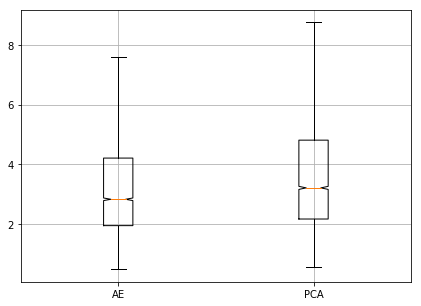

In [51]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# Super Deep Encoder

In [52]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_sdeep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sdeep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 80),
                                     activation_layer,
                                     nn.Linear(80, 60),
                                     activation_layer,
                                     nn.Linear(60, 45),
                                     activation_layer,
                                     nn.Linear(45, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, 8),
                                     activation_layer,
                                     nn.Linear(8, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 8),
                                     activation_layer,
                                     nn.Linear(8, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 45),
                                     activation_layer,
                                     nn.Linear(45, 60),
                                     activation_layer,
                                     nn.Linear(60, 80),
                                     activation_layer,
                                     nn.Linear(80, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [73]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

embedding_size = 4

ae_54 = autoencoder_sdeep(length, embedding_size).cuda()
ae_54.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_sdeep(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52 = train_ae(ae_52, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Saving relevant files

# Saving Losses
np.save('models/final_models/losses_6_4', np.array(losses_54))
np.save('models/final_models/losses_6_2', np.array(losses_52))


# Saving Models
torch.save(ae_54, 'models/final_models/ae_6_4.pt') #Saving the autoencoder model
torch.save(ae_52, 'models/final_models/ae_6_2.pt') #Saving the autoencoder model

TOTAL PARAMETERS FOR MODEL: 45021
epoch [1/350000], loss:1627.37145996, avg:1627.37145996
epoch [101/350000], loss:1060.76916504, avg:1090.38476562
epoch [201/350000], loss:267.53518677, avg:285.04275513
epoch [301/350000], loss:236.83233643, avg:237.44885254
epoch [401/350000], loss:258.48114014, avg:238.80723572
epoch [501/350000], loss:222.54608154, avg:235.50959778
epoch [601/350000], loss:233.45857239, avg:218.82966614
epoch [701/350000], loss:169.98643494, avg:171.41461182
epoch [801/350000], loss:149.34757996, avg:145.02883911
epoch [901/350000], loss:147.36996460, avg:142.77372742
epoch [1001/350000], loss:138.43211365, avg:143.68124390
epoch [1101/350000], loss:142.70547485, avg:141.87547302
epoch [1201/350000], loss:145.98086548, avg:139.63308716
epoch [1301/350000], loss:145.99771118, avg:139.56147766
epoch [1401/350000], loss:133.48773193, avg:137.29878235
epoch [1501/350000], loss:123.76056671, avg:132.49993896
epoch [1601/350000], loss:137.95364380, avg:140.65431213
epoch

epoch [14601/350000], loss:87.66235352, avg:88.39050293
epoch [14701/350000], loss:86.25047302, avg:89.19972992
epoch [14801/350000], loss:88.89842987, avg:86.15525818
epoch [14901/350000], loss:94.86194611, avg:87.76757050
epoch [15001/350000], loss:86.67780304, avg:86.88173676
epoch [15101/350000], loss:84.11594391, avg:87.87046051
epoch [15201/350000], loss:89.82907104, avg:88.54659271
epoch [15301/350000], loss:83.72950745, avg:86.43900299
epoch [15401/350000], loss:86.11936951, avg:87.40182495
epoch [15501/350000], loss:84.35114288, avg:87.56254578
epoch [15601/350000], loss:87.82367706, avg:87.11698151
epoch [15701/350000], loss:86.37441254, avg:87.33280182
epoch [15801/350000], loss:96.08708954, avg:87.60222626
epoch [15901/350000], loss:85.28529358, avg:87.94872284
epoch [16001/350000], loss:88.11055756, avg:87.88733673
epoch [16101/350000], loss:85.41488647, avg:87.26759338
epoch [16201/350000], loss:85.22776031, avg:87.91057587
epoch [16301/350000], loss:91.69347382, avg:88.0

epoch [29301/350000], loss:79.39638519, avg:80.77862549
epoch [29401/350000], loss:79.64571381, avg:80.32272339
epoch [29501/350000], loss:77.87554932, avg:78.47759247
epoch [29601/350000], loss:85.20587921, avg:80.60313416
epoch [29701/350000], loss:80.37802124, avg:80.12758636
epoch [29801/350000], loss:78.36416626, avg:80.51352692
epoch [29901/350000], loss:83.59171295, avg:81.60738373
epoch [30001/350000], loss:82.02442932, avg:80.15493774
epoch [30101/350000], loss:75.34536743, avg:78.89086151
epoch [30201/350000], loss:78.14649200, avg:81.32668304
epoch [30301/350000], loss:81.09390259, avg:81.95208740
epoch [30401/350000], loss:81.94870758, avg:80.68875122
epoch [30501/350000], loss:81.23566437, avg:79.78159332
epoch [30601/350000], loss:81.95803070, avg:80.89531708
epoch [30701/350000], loss:80.36109924, avg:78.99423981
epoch [30801/350000], loss:79.67263794, avg:80.52546692
epoch [30901/350000], loss:80.71446228, avg:80.68827820
epoch [31001/350000], loss:80.27820587, avg:78.9

epoch [44001/350000], loss:81.19581604, avg:80.26837158
epoch [44101/350000], loss:80.23186493, avg:78.76434326
epoch [44201/350000], loss:82.15274811, avg:78.21469116
epoch [44301/350000], loss:77.65220642, avg:78.80937958
epoch [44401/350000], loss:72.24456787, avg:77.33156586
epoch [44501/350000], loss:76.01171875, avg:78.75408173
epoch [44601/350000], loss:78.07791901, avg:77.09751892
epoch [44701/350000], loss:75.59815216, avg:78.57542419
epoch [44801/350000], loss:76.10087585, avg:76.49825287
epoch [44901/350000], loss:80.54674530, avg:78.75938416
epoch [45001/350000], loss:77.24650574, avg:79.09951019
epoch [45101/350000], loss:74.98793793, avg:77.37005615
epoch [45201/350000], loss:76.16650391, avg:78.21723938
epoch [45301/350000], loss:77.19956207, avg:78.55834198
epoch [45401/350000], loss:77.71750641, avg:77.89727783
epoch [45501/350000], loss:75.38157654, avg:77.70433044
epoch [45601/350000], loss:79.54563904, avg:78.51673889
epoch [45701/350000], loss:83.52632904, avg:76.6

epoch [58701/350000], loss:77.70265961, avg:76.90814972
epoch [58801/350000], loss:76.81874084, avg:77.60182190
epoch [58901/350000], loss:78.18202972, avg:77.44402313
epoch [59001/350000], loss:71.88873291, avg:76.30329895
epoch [59101/350000], loss:74.74695587, avg:76.93764496
epoch [59201/350000], loss:76.11735535, avg:76.62308502
epoch [59301/350000], loss:76.35193634, avg:78.13083649
epoch [59401/350000], loss:79.70773315, avg:77.08172607
epoch [59501/350000], loss:80.30266571, avg:77.54559326
epoch [59601/350000], loss:79.65318298, avg:77.25438690
epoch [59701/350000], loss:76.07317352, avg:78.32861328
epoch [59801/350000], loss:78.75889587, avg:78.36383820
epoch [59901/350000], loss:71.62316895, avg:77.37866974
epoch [60001/350000], loss:78.77423096, avg:78.01475525
epoch [60101/350000], loss:77.52047729, avg:78.26222229
epoch [60201/350000], loss:73.11286926, avg:75.58790588
epoch [60301/350000], loss:76.38803101, avg:76.84199524
epoch [60401/350000], loss:76.06963348, avg:76.8

epoch [73401/350000], loss:77.51852417, avg:76.61684418
epoch [73501/350000], loss:79.52077484, avg:76.15718842
epoch [73601/350000], loss:82.14048767, avg:78.13402557
epoch [73701/350000], loss:75.40332031, avg:75.79847717
epoch [73801/350000], loss:73.65905762, avg:76.41259766
epoch [73901/350000], loss:73.31161499, avg:76.22749329
epoch [74001/350000], loss:75.44065857, avg:77.70273590
epoch [74101/350000], loss:75.16654968, avg:75.93968201
epoch [74201/350000], loss:77.71606445, avg:76.91400146
epoch [74301/350000], loss:74.83897400, avg:77.83055878
epoch [74401/350000], loss:80.29736328, avg:76.76856995
epoch [74501/350000], loss:76.59349823, avg:76.20682526
epoch [74601/350000], loss:82.61478424, avg:78.67149353
epoch [74701/350000], loss:75.72667694, avg:76.92836761
epoch [74801/350000], loss:75.01729584, avg:76.59898376
epoch [74901/350000], loss:73.29699707, avg:76.57298279
epoch [75001/350000], loss:72.36913300, avg:76.12926483
epoch [75101/350000], loss:70.79800415, avg:76.5

epoch [88101/350000], loss:76.16053772, avg:76.36956024
epoch [88201/350000], loss:77.25425720, avg:77.14132690
epoch [88301/350000], loss:73.18235016, avg:75.20320129
epoch [88401/350000], loss:75.88925171, avg:76.30555725
epoch [88501/350000], loss:74.48741913, avg:75.42851257
epoch [88601/350000], loss:79.58632660, avg:74.68497467
epoch [88701/350000], loss:77.77467346, avg:77.02500916
epoch [88801/350000], loss:80.57256317, avg:75.55799103
epoch [88901/350000], loss:74.95460510, avg:77.32448578
epoch [89001/350000], loss:75.51245117, avg:75.30281067
epoch [89101/350000], loss:77.10393524, avg:75.73633575
epoch [89201/350000], loss:75.61944580, avg:76.74116516
epoch [89301/350000], loss:70.12058258, avg:75.79411316
epoch [89401/350000], loss:76.06620789, avg:75.86000824
epoch [89501/350000], loss:73.07077789, avg:75.83169556
epoch [89601/350000], loss:74.14167786, avg:75.13703918
epoch [89701/350000], loss:75.03668213, avg:77.00870514
epoch [89801/350000], loss:76.79022217, avg:75.9

epoch [102701/350000], loss:80.28079224, avg:75.14066315
epoch [102801/350000], loss:78.33081818, avg:74.03254700
epoch [102901/350000], loss:77.70412445, avg:75.96955872
epoch [103001/350000], loss:77.65470886, avg:76.34190369
epoch [103101/350000], loss:78.99234772, avg:76.86634827
epoch [103201/350000], loss:75.59068298, avg:75.46696472
epoch [103301/350000], loss:80.61045837, avg:76.80639648
epoch [103401/350000], loss:71.36674500, avg:75.51980591
epoch [103501/350000], loss:76.37008667, avg:76.24575043
epoch [103601/350000], loss:76.55236053, avg:76.16732025
epoch [103701/350000], loss:77.77847290, avg:77.47340393
epoch [103801/350000], loss:75.69688416, avg:75.22484589
epoch [103901/350000], loss:75.87581635, avg:75.20991516
epoch [104001/350000], loss:77.27126312, avg:77.62989044
epoch [104101/350000], loss:73.82614899, avg:76.57598114
epoch [104201/350000], loss:75.41483307, avg:76.33016205
epoch [104301/350000], loss:77.98976135, avg:78.63765717
epoch [104401/350000], loss:79.

epoch [117101/350000], loss:74.81614685, avg:73.33426666
epoch [117201/350000], loss:74.28697968, avg:74.63002777
epoch [117301/350000], loss:77.69420624, avg:75.77164459
epoch [117401/350000], loss:75.91825867, avg:74.57270050
epoch [117501/350000], loss:72.20635986, avg:74.93521118
epoch [117601/350000], loss:76.78835297, avg:74.52125549
epoch [117701/350000], loss:79.31874084, avg:76.20912933
epoch [117801/350000], loss:80.52471161, avg:74.99617767
epoch [117901/350000], loss:71.74217224, avg:73.68382263
epoch [118001/350000], loss:73.12483215, avg:74.60586548
epoch [118101/350000], loss:75.19802094, avg:74.21845245
epoch [118201/350000], loss:72.25901794, avg:75.01530457
epoch [118301/350000], loss:76.83529663, avg:74.83567047
epoch [118401/350000], loss:70.67277527, avg:73.75205994
epoch [118501/350000], loss:71.95050812, avg:74.12975311
epoch [118601/350000], loss:74.16055298, avg:74.28081512
epoch [118701/350000], loss:73.70407867, avg:74.20440674
epoch [118801/350000], loss:76.

epoch [131501/350000], loss:75.19212341, avg:74.82183838
epoch [131601/350000], loss:76.26209259, avg:75.02246857
epoch [131701/350000], loss:73.87465668, avg:74.86354828
epoch [131801/350000], loss:73.88129425, avg:75.63947296
epoch [131901/350000], loss:73.16397858, avg:75.16211700
epoch [132001/350000], loss:78.58778381, avg:75.00011444
epoch [132101/350000], loss:75.29317474, avg:74.98925018
epoch [132201/350000], loss:73.89264679, avg:75.64787292
epoch [132301/350000], loss:77.65737152, avg:75.72861481
epoch [132401/350000], loss:73.87130737, avg:74.51110077
epoch [132501/350000], loss:76.23338318, avg:74.56385803
epoch [132601/350000], loss:75.59683990, avg:76.20371246
epoch [132701/350000], loss:75.18466187, avg:74.97676086
epoch [132801/350000], loss:75.13941956, avg:75.06509399
epoch [132901/350000], loss:73.80084991, avg:74.78624725
epoch [133001/350000], loss:81.03030396, avg:75.85798645
epoch [133101/350000], loss:75.53314209, avg:73.83626556
epoch [133201/350000], loss:76.

epoch [145901/350000], loss:71.97578430, avg:75.02574158
epoch [146001/350000], loss:74.68399048, avg:74.50377655
epoch [146101/350000], loss:76.54526520, avg:74.17131042
epoch [146201/350000], loss:74.82237244, avg:74.35370636
epoch [146301/350000], loss:75.89344788, avg:74.99574280
epoch [146401/350000], loss:75.73949432, avg:76.09178162
epoch [146501/350000], loss:76.21351624, avg:76.29071045
epoch [146601/350000], loss:77.84200287, avg:75.72322845
epoch [146701/350000], loss:73.30822754, avg:75.04865265
epoch [146801/350000], loss:75.89854431, avg:75.76140594
epoch [146901/350000], loss:76.97898102, avg:76.28943634
epoch [147001/350000], loss:77.04335022, avg:76.95092010
epoch [147101/350000], loss:77.69243622, avg:75.56181335
epoch [147201/350000], loss:77.75011444, avg:77.50154877
epoch [147301/350000], loss:82.70573425, avg:76.59085083
epoch [147401/350000], loss:73.82485199, avg:75.99962616
epoch [147501/350000], loss:80.23909760, avg:75.64642334
epoch [147601/350000], loss:79.

epoch [160301/350000], loss:74.01493835, avg:73.42426300
epoch [160401/350000], loss:69.66937256, avg:73.58660889
epoch [160501/350000], loss:70.40301514, avg:72.88237000
epoch [160601/350000], loss:74.17748260, avg:73.70611572
epoch [160701/350000], loss:73.73950195, avg:74.67704773
epoch [160801/350000], loss:78.91390991, avg:75.29322815
epoch [160901/350000], loss:73.90147400, avg:75.54625702
epoch [161001/350000], loss:75.53616333, avg:73.53479004
epoch [161101/350000], loss:74.71625519, avg:73.70814514
epoch [161201/350000], loss:79.30464172, avg:75.31786346
epoch [161301/350000], loss:71.28795624, avg:73.52157593
epoch [161401/350000], loss:72.54550934, avg:73.68961334
epoch [161501/350000], loss:70.76015472, avg:74.19527435
epoch [161601/350000], loss:71.66140747, avg:74.97165680
epoch [161701/350000], loss:75.00967407, avg:73.86333466
epoch [161801/350000], loss:77.46617889, avg:74.03310394
epoch [161901/350000], loss:77.30480957, avg:75.41054535
epoch [162001/350000], loss:70.

epoch [174701/350000], loss:71.73578644, avg:71.71997833
epoch [174801/350000], loss:72.67629242, avg:74.78895569
epoch [174901/350000], loss:77.60138702, avg:74.98654938
epoch [175001/350000], loss:72.89067078, avg:72.37191010
epoch [175101/350000], loss:76.69693756, avg:73.91010284
epoch [175201/350000], loss:71.96664429, avg:73.96598053
epoch [175301/350000], loss:76.49951172, avg:74.60521698
epoch [175401/350000], loss:74.00704193, avg:73.39192963
epoch [175501/350000], loss:73.31787109, avg:73.65224457
epoch [175601/350000], loss:75.73879242, avg:73.63335419
epoch [175701/350000], loss:72.76045990, avg:75.16107178
epoch [175801/350000], loss:73.32438660, avg:73.00210571
epoch [175901/350000], loss:71.93327332, avg:73.33318329
epoch [176001/350000], loss:74.40816498, avg:75.28380585
epoch [176101/350000], loss:73.22392273, avg:74.03649902
epoch [176201/350000], loss:74.78733063, avg:73.24311066
epoch [176301/350000], loss:72.48594666, avg:73.75582123
epoch [176401/350000], loss:74.

epoch [189101/350000], loss:73.80166626, avg:76.37258148
epoch [189201/350000], loss:76.67197418, avg:75.51340485
epoch [189301/350000], loss:76.16053009, avg:75.36629486
epoch [189401/350000], loss:76.69106293, avg:75.54680634
epoch [189501/350000], loss:73.08627319, avg:75.21545410
epoch [189601/350000], loss:74.96845245, avg:74.72386169
epoch [189701/350000], loss:74.69803619, avg:75.02623749
epoch [189801/350000], loss:75.43353271, avg:75.32185364
epoch [189901/350000], loss:73.30537415, avg:75.60972595
epoch [190001/350000], loss:73.04140472, avg:74.23946381
epoch [190101/350000], loss:71.97677612, avg:74.06821442
epoch [190201/350000], loss:77.11856079, avg:74.72352600
epoch [190301/350000], loss:73.93025208, avg:73.22084808
epoch [190401/350000], loss:72.14593506, avg:73.41037750
epoch [190501/350000], loss:71.88861084, avg:73.55125427
epoch [190601/350000], loss:78.28157043, avg:74.78874969
epoch [190701/350000], loss:72.43367004, avg:73.09988403
epoch [190801/350000], loss:74.

epoch [203501/350000], loss:71.76149750, avg:73.77003479
epoch [203601/350000], loss:72.40560150, avg:72.99141693
epoch [203701/350000], loss:72.69078064, avg:73.18656158
epoch [203801/350000], loss:70.08986664, avg:71.96120453
epoch [203901/350000], loss:71.91030884, avg:72.06340790
epoch [204001/350000], loss:71.75710297, avg:71.52836609
epoch [204101/350000], loss:70.13629913, avg:71.00962067
epoch [204201/350000], loss:70.11605835, avg:71.85770416
epoch [204301/350000], loss:74.71579742, avg:71.96010590
epoch [204401/350000], loss:69.55163574, avg:71.18273926
epoch [204501/350000], loss:71.45359802, avg:71.67021179
epoch [204601/350000], loss:70.56215668, avg:72.01113129
epoch [204701/350000], loss:75.61224365, avg:71.83596802
epoch [204801/350000], loss:72.62693024, avg:71.22432709
epoch [204901/350000], loss:75.07636261, avg:72.73245239
epoch [205001/350000], loss:69.86717224, avg:71.72090149
epoch [205101/350000], loss:68.32098389, avg:70.65873718
epoch [205201/350000], loss:74.

epoch [217901/350000], loss:69.61095428, avg:70.08792114
epoch [218001/350000], loss:70.93763733, avg:69.83308411
epoch [218101/350000], loss:66.17871857, avg:69.59518433
epoch [218201/350000], loss:73.52999878, avg:69.83853912
epoch [218301/350000], loss:73.26179504, avg:69.46051025
epoch [218401/350000], loss:68.27649689, avg:69.30451202
epoch [218501/350000], loss:71.13972473, avg:69.85404968
epoch [218601/350000], loss:70.65522003, avg:70.22879791
epoch [218701/350000], loss:66.70590210, avg:69.47867584
epoch [218801/350000], loss:68.87276459, avg:70.24977875
epoch [218901/350000], loss:70.13810730, avg:70.40726471
epoch [219001/350000], loss:67.36746979, avg:69.93752289
epoch [219101/350000], loss:71.80924225, avg:71.80300140
epoch [219201/350000], loss:71.02674103, avg:71.09922028
epoch [219301/350000], loss:68.15052795, avg:68.84232330
epoch [219401/350000], loss:68.18059540, avg:69.17300415
epoch [219501/350000], loss:73.43743134, avg:70.48799896
epoch [219601/350000], loss:69.

epoch [232301/350000], loss:70.22885895, avg:69.70191956
epoch [232401/350000], loss:65.56835175, avg:67.25975800
epoch [232501/350000], loss:66.91992950, avg:68.21360016
epoch [232601/350000], loss:69.81271362, avg:69.21527100
epoch [232701/350000], loss:66.69492340, avg:67.37561035
epoch [232801/350000], loss:65.33554840, avg:66.61532593
epoch [232901/350000], loss:67.12152100, avg:67.99721527
epoch [233001/350000], loss:69.30802917, avg:68.62429810
epoch [233101/350000], loss:67.34669495, avg:66.44673920
epoch [233201/350000], loss:67.95481873, avg:66.82613373
epoch [233301/350000], loss:70.20420074, avg:69.02187347
epoch [233401/350000], loss:70.51844025, avg:68.18729401
epoch [233501/350000], loss:70.71563721, avg:67.88436890
epoch [233601/350000], loss:69.44217682, avg:67.33599091
epoch [233701/350000], loss:63.85433578, avg:67.80718231
epoch [233801/350000], loss:69.74578094, avg:68.60146332
epoch [233901/350000], loss:69.96874237, avg:67.10479736
epoch [234001/350000], loss:69.

epoch [246701/350000], loss:62.01134872, avg:65.89912415
epoch [246801/350000], loss:64.27272797, avg:65.93462372
epoch [246901/350000], loss:67.60702515, avg:64.81185150
epoch [247001/350000], loss:66.96591187, avg:66.23513031
epoch [247101/350000], loss:64.30467224, avg:66.90686798
epoch [247201/350000], loss:64.35411835, avg:66.57848358
epoch [247301/350000], loss:69.75231934, avg:66.14873505
epoch [247401/350000], loss:65.22640228, avg:66.03124237
epoch [247501/350000], loss:64.56452179, avg:65.18152618
epoch [247601/350000], loss:66.85974121, avg:65.16139984
epoch [247701/350000], loss:65.25956726, avg:66.85691071
epoch [247801/350000], loss:68.01560211, avg:66.29589081
epoch [247901/350000], loss:63.76940536, avg:66.39294434
epoch [248001/350000], loss:67.85386658, avg:67.18936157
epoch [248101/350000], loss:65.59951782, avg:66.15897369
epoch [248201/350000], loss:66.42592621, avg:65.38011169
epoch [248301/350000], loss:65.43138123, avg:65.42951965
epoch [248401/350000], loss:66.

epoch [261101/350000], loss:64.43112946, avg:63.41650009
epoch [261201/350000], loss:61.42753220, avg:64.67153168
epoch [261301/350000], loss:65.67472839, avg:64.49124146
epoch [261401/350000], loss:58.74402618, avg:62.89718246
epoch [261501/350000], loss:65.12172699, avg:63.20299911
epoch [261601/350000], loss:63.84401321, avg:64.26638031
epoch [261701/350000], loss:63.09481049, avg:63.71986008
epoch [261801/350000], loss:62.30749893, avg:64.18321991
epoch [261901/350000], loss:63.88414383, avg:64.17916107
epoch [262001/350000], loss:63.34598160, avg:63.86060333
epoch [262101/350000], loss:64.68758392, avg:64.35987091
epoch [262201/350000], loss:63.92070770, avg:63.08687210
epoch [262301/350000], loss:64.82884216, avg:63.60791779
epoch [262401/350000], loss:68.62707520, avg:65.19891357
epoch [262501/350000], loss:60.80443573, avg:62.74536133
epoch [262601/350000], loss:62.61473083, avg:65.01582336
epoch [262701/350000], loss:65.44821167, avg:64.84246063
epoch [262801/350000], loss:67.

epoch [275501/350000], loss:61.71118927, avg:62.53436279
epoch [275601/350000], loss:61.86798859, avg:61.72358322
epoch [275701/350000], loss:58.73761749, avg:62.85247421
epoch [275801/350000], loss:59.85962296, avg:61.74155426
epoch [275901/350000], loss:62.07574844, avg:60.95200729
epoch [276001/350000], loss:60.46517944, avg:62.34379959
epoch [276101/350000], loss:59.66183853, avg:62.20212936
epoch [276201/350000], loss:62.55365753, avg:62.85218430
epoch [276301/350000], loss:60.65520477, avg:61.70407867
epoch [276401/350000], loss:60.58522415, avg:62.72948074
epoch [276501/350000], loss:60.58200836, avg:61.42570877
epoch [276601/350000], loss:62.61994171, avg:62.50744247
epoch [276701/350000], loss:60.37282944, avg:61.94143677
epoch [276801/350000], loss:61.57955551, avg:62.44304276
epoch [276901/350000], loss:62.28355789, avg:62.53715897
epoch [277001/350000], loss:60.71009445, avg:62.07337570
epoch [277101/350000], loss:65.64460754, avg:62.57537842
epoch [277201/350000], loss:61.

epoch [289901/350000], loss:62.50184250, avg:62.37027740
epoch [290001/350000], loss:59.29401016, avg:61.41552734
epoch [290101/350000], loss:62.20141220, avg:62.13430405
epoch [290201/350000], loss:58.71630859, avg:61.95678329
epoch [290301/350000], loss:62.54695511, avg:61.95896530
epoch [290401/350000], loss:60.15512085, avg:61.72459793
epoch [290501/350000], loss:63.31000519, avg:62.10491562
epoch [290601/350000], loss:65.00228119, avg:61.23226929
epoch [290701/350000], loss:60.97106171, avg:62.59799194
epoch [290801/350000], loss:62.76007080, avg:61.45973587
epoch [290901/350000], loss:62.63048935, avg:61.03584671
epoch [291001/350000], loss:61.53694534, avg:61.20102692
epoch [291101/350000], loss:61.79911041, avg:62.19749832
epoch [291201/350000], loss:60.41712189, avg:61.49723434
epoch [291301/350000], loss:62.62159348, avg:61.69245148
epoch [291401/350000], loss:61.34289551, avg:62.37978745
epoch [291501/350000], loss:59.85904312, avg:60.87931061
epoch [291601/350000], loss:59.

epoch [304301/350000], loss:59.96596146, avg:63.02820587
epoch [304401/350000], loss:63.72017288, avg:63.43056107
epoch [304501/350000], loss:59.94432831, avg:63.42666626
epoch [304601/350000], loss:62.48513794, avg:62.13767242
epoch [304701/350000], loss:62.23583984, avg:62.52788925
epoch [304801/350000], loss:64.44155884, avg:62.66022873
epoch [304901/350000], loss:62.29713058, avg:63.62323761
epoch [305001/350000], loss:62.41017151, avg:63.97644806
epoch [305101/350000], loss:64.41674042, avg:61.62445068
epoch [305201/350000], loss:60.99981308, avg:63.15029526
epoch [305301/350000], loss:61.85112000, avg:62.75344849
epoch [305401/350000], loss:67.98704529, avg:63.28676987
epoch [305501/350000], loss:65.43141174, avg:64.16867065
epoch [305601/350000], loss:65.54562378, avg:64.01869965
epoch [305701/350000], loss:62.18953705, avg:63.03388214
epoch [305801/350000], loss:63.58758163, avg:63.31934357
epoch [305901/350000], loss:65.94601440, avg:62.86338043
epoch [306001/350000], loss:61.

epoch [318701/350000], loss:63.67860794, avg:63.44384766
epoch [318801/350000], loss:60.36338425, avg:61.61648178
epoch [318901/350000], loss:60.47216797, avg:62.39099884
epoch [319001/350000], loss:64.39168549, avg:62.03097153
epoch [319101/350000], loss:64.70793915, avg:62.97564316
epoch [319201/350000], loss:63.34525299, avg:62.81524277
epoch [319301/350000], loss:64.71891785, avg:62.37415314
epoch [319401/350000], loss:61.83034134, avg:62.14545822
epoch [319501/350000], loss:62.82529831, avg:62.99564743
epoch [319601/350000], loss:62.37206650, avg:62.80499268
epoch [319701/350000], loss:62.12632370, avg:62.80315018
epoch [319801/350000], loss:64.33389282, avg:62.31674957
epoch [319901/350000], loss:62.64030075, avg:61.96505737
epoch [320001/350000], loss:61.59974289, avg:63.45597076
epoch [320101/350000], loss:60.17766190, avg:63.14057541
epoch [320201/350000], loss:59.90643692, avg:61.90282822
epoch [320301/350000], loss:63.55350494, avg:61.85937119
epoch [320401/350000], loss:59.

epoch [333101/350000], loss:59.16703415, avg:60.96208572
epoch [333201/350000], loss:59.76310730, avg:60.67042923
epoch [333301/350000], loss:61.19235229, avg:60.43996811
epoch [333401/350000], loss:62.94242477, avg:60.96552277
epoch [333501/350000], loss:63.44232941, avg:62.41604233
epoch [333601/350000], loss:58.20191956, avg:60.76229477
epoch [333701/350000], loss:59.47464752, avg:59.45392990
epoch [333801/350000], loss:60.54483032, avg:61.44328690
epoch [333901/350000], loss:58.65435791, avg:61.21007919
epoch [334001/350000], loss:61.30397415, avg:61.40411377
epoch [334101/350000], loss:60.95385742, avg:61.01864243
epoch [334201/350000], loss:59.97632980, avg:60.49564362
epoch [334301/350000], loss:61.47870255, avg:60.96496201
epoch [334401/350000], loss:59.51338196, avg:61.43205643
epoch [334501/350000], loss:65.39675903, avg:61.22530746
epoch [334601/350000], loss:62.56791687, avg:60.46973419
epoch [334701/350000], loss:60.55208969, avg:61.66950226
epoch [334801/350000], loss:59.

epoch [347501/350000], loss:60.00334930, avg:60.05920029
epoch [347601/350000], loss:59.31123352, avg:59.43667603
epoch [347701/350000], loss:61.06712341, avg:60.44198227
epoch [347801/350000], loss:60.42681503, avg:60.25540924
epoch [347901/350000], loss:59.88286591, avg:60.18294144
epoch [348001/350000], loss:59.02689362, avg:59.73279953
epoch [348101/350000], loss:59.01660919, avg:59.11170578
epoch [348201/350000], loss:58.65319061, avg:59.35186768
epoch [348301/350000], loss:59.83562469, avg:60.50827789
epoch [348401/350000], loss:59.97144699, avg:59.72774124
epoch [348501/350000], loss:60.94733810, avg:60.03103256
epoch [348601/350000], loss:57.91332245, avg:59.27291870
epoch [348701/350000], loss:58.32033539, avg:59.67854691
epoch [348801/350000], loss:58.14448547, avg:60.06613922
epoch [348901/350000], loss:61.45903778, avg:60.65172195
epoch [349001/350000], loss:60.47856140, avg:60.25430298
epoch [349101/350000], loss:64.38643646, avg:60.89600754
epoch [349201/350000], loss:61.

epoch [11801/350000], loss:129.57554626, avg:129.29913330
epoch [11901/350000], loss:125.41292572, avg:126.65840912
epoch [12001/350000], loss:119.94315338, avg:126.20886230
epoch [12101/350000], loss:127.16072083, avg:132.56890869
epoch [12201/350000], loss:119.77499390, avg:127.74327850
epoch [12301/350000], loss:118.47040558, avg:126.23384094
epoch [12401/350000], loss:137.09056091, avg:128.09001160
epoch [12501/350000], loss:122.22743225, avg:123.69533539
epoch [12601/350000], loss:128.83349609, avg:128.51936340
epoch [12701/350000], loss:130.42668152, avg:128.66629028
epoch [12801/350000], loss:122.98545837, avg:124.63352203
epoch [12901/350000], loss:133.09170532, avg:127.61193085
epoch [13001/350000], loss:125.72214508, avg:123.07407379
epoch [13101/350000], loss:121.46367645, avg:130.63685608
epoch [13201/350000], loss:131.22918701, avg:131.58483887
epoch [13301/350000], loss:122.32926941, avg:130.48271179
epoch [13401/350000], loss:130.80714417, avg:125.04067230
epoch [13501/3

epoch [26001/350000], loss:115.43246460, avg:120.48054504
epoch [26101/350000], loss:128.02622986, avg:120.05659485
epoch [26201/350000], loss:120.55739594, avg:119.34877777
epoch [26301/350000], loss:112.52651978, avg:118.85929108
epoch [26401/350000], loss:114.50835419, avg:118.47090149
epoch [26501/350000], loss:122.68091583, avg:114.72087860
epoch [26601/350000], loss:119.90771484, avg:119.61220551
epoch [26701/350000], loss:118.06649017, avg:121.10523987
epoch [26801/350000], loss:126.76564026, avg:118.72589111
epoch [26901/350000], loss:116.72138977, avg:117.45788574
epoch [27001/350000], loss:115.69471741, avg:117.62462616
epoch [27101/350000], loss:129.69505310, avg:122.60296631
epoch [27201/350000], loss:114.62220764, avg:117.22839355
epoch [27301/350000], loss:114.98065948, avg:117.41027069
epoch [27401/350000], loss:109.03174591, avg:116.91378021
epoch [27501/350000], loss:119.12354279, avg:116.31725311
epoch [27601/350000], loss:127.45730591, avg:119.60439301
epoch [27701/3

epoch [40201/350000], loss:105.50665283, avg:106.84702301
epoch [40301/350000], loss:107.85336304, avg:107.41554260
epoch [40401/350000], loss:109.22393036, avg:109.61274719
epoch [40501/350000], loss:110.56218719, avg:107.44915009
epoch [40601/350000], loss:121.42524719, avg:110.02453613
epoch [40701/350000], loss:102.70841217, avg:105.22724915
epoch [40801/350000], loss:104.98638153, avg:105.55901337
epoch [40901/350000], loss:106.29515076, avg:106.20936584
epoch [41001/350000], loss:110.55191040, avg:106.86048889
epoch [41101/350000], loss:107.83917999, avg:105.05175018
epoch [41201/350000], loss:106.01191711, avg:108.09571838
epoch [41301/350000], loss:109.74108124, avg:105.77129364
epoch [41401/350000], loss:104.98559570, avg:107.60338593
epoch [41501/350000], loss:108.21008301, avg:107.19683838
epoch [41601/350000], loss:99.15868378, avg:105.50453186
epoch [41701/350000], loss:105.88293457, avg:105.90100098
epoch [41801/350000], loss:105.67351532, avg:110.04573059
epoch [41901/35

epoch [54401/350000], loss:104.35323334, avg:105.31573486
epoch [54501/350000], loss:106.36851501, avg:105.32759857
epoch [54601/350000], loss:114.17463684, avg:105.62982178
epoch [54701/350000], loss:99.52993774, avg:102.99027252
epoch [54801/350000], loss:110.88042450, avg:105.39276123
epoch [54901/350000], loss:99.83018494, avg:105.00473785
epoch [55001/350000], loss:108.80515289, avg:107.21337891
epoch [55101/350000], loss:103.38773346, avg:105.56945801
epoch [55201/350000], loss:103.26699066, avg:106.61101532
epoch [55301/350000], loss:103.39061737, avg:107.98513031
epoch [55401/350000], loss:101.06701660, avg:106.33907318
epoch [55501/350000], loss:112.07272339, avg:110.10990143
epoch [55601/350000], loss:114.82008362, avg:108.96871185
epoch [55701/350000], loss:103.69470215, avg:110.76689911
epoch [55801/350000], loss:110.99566650, avg:114.59028625
epoch [55901/350000], loss:106.76017761, avg:109.03548431
epoch [56001/350000], loss:104.20655060, avg:103.18215179
epoch [56101/350

epoch [68601/350000], loss:102.00742340, avg:104.05792236
epoch [68701/350000], loss:106.91616058, avg:104.08235168
epoch [68801/350000], loss:108.50704956, avg:104.24826813
epoch [68901/350000], loss:105.97308350, avg:103.12387848
epoch [69001/350000], loss:105.45442200, avg:103.76653290
epoch [69101/350000], loss:98.81367493, avg:104.90996552
epoch [69201/350000], loss:102.65086365, avg:103.50345612
epoch [69301/350000], loss:115.90034485, avg:103.46626282
epoch [69401/350000], loss:104.18527222, avg:104.54483795
epoch [69501/350000], loss:106.66936493, avg:105.82662201
epoch [69601/350000], loss:102.15319824, avg:107.47885895
epoch [69701/350000], loss:104.45002747, avg:106.61370087
epoch [69801/350000], loss:102.68220520, avg:103.92718506
epoch [69901/350000], loss:111.00215149, avg:105.60599518
epoch [70001/350000], loss:111.55519867, avg:108.89038086
epoch [70101/350000], loss:99.20625305, avg:107.74404144
epoch [70201/350000], loss:109.48036957, avg:106.05696869
epoch [70301/350

epoch [82801/350000], loss:109.35350037, avg:105.03248596
epoch [82901/350000], loss:96.39275360, avg:102.52500153
epoch [83001/350000], loss:102.31383514, avg:102.05463409
epoch [83101/350000], loss:103.55325317, avg:99.78325653
epoch [83201/350000], loss:106.11930847, avg:103.04866791
epoch [83301/350000], loss:105.86751556, avg:102.97004700
epoch [83401/350000], loss:100.84637451, avg:103.45906067
epoch [83501/350000], loss:107.58255768, avg:103.20604706
epoch [83601/350000], loss:110.09555817, avg:107.81795502
epoch [83701/350000], loss:111.71278381, avg:105.49697113
epoch [83801/350000], loss:103.26707458, avg:103.06064606
epoch [83901/350000], loss:113.73680115, avg:104.19715881
epoch [84001/350000], loss:112.38829803, avg:104.86793518
epoch [84101/350000], loss:113.38100433, avg:109.95146942
epoch [84201/350000], loss:105.84826660, avg:105.36077118
epoch [84301/350000], loss:104.66648865, avg:103.38867188
epoch [84401/350000], loss:98.52362823, avg:104.47618866
epoch [84501/3500

epoch [97001/350000], loss:112.52102661, avg:109.13642883
epoch [97101/350000], loss:104.13326263, avg:107.50554657
epoch [97201/350000], loss:109.10931396, avg:105.80849457
epoch [97301/350000], loss:102.17011261, avg:106.01936340
epoch [97401/350000], loss:108.08754730, avg:107.41728973
epoch [97501/350000], loss:108.32401276, avg:107.32790375
epoch [97601/350000], loss:109.25402069, avg:108.26069641
epoch [97701/350000], loss:103.68296051, avg:106.09480286
epoch [97801/350000], loss:101.15373230, avg:104.36608124
epoch [97901/350000], loss:103.93234253, avg:105.77613831
epoch [98001/350000], loss:109.95256042, avg:105.14660645
epoch [98101/350000], loss:108.27634430, avg:105.09696198
epoch [98201/350000], loss:107.88964844, avg:104.94947815
epoch [98301/350000], loss:113.95587158, avg:108.10234833
epoch [98401/350000], loss:116.62544250, avg:104.70092773
epoch [98501/350000], loss:105.54782867, avg:104.19575500
epoch [98601/350000], loss:97.17687988, avg:104.36547852
epoch [98701/35

epoch [111001/350000], loss:103.95584106, avg:105.29514313
epoch [111101/350000], loss:117.22486877, avg:107.62202454
epoch [111201/350000], loss:103.08329773, avg:106.10186768
epoch [111301/350000], loss:106.04380035, avg:104.30159760
epoch [111401/350000], loss:107.56477356, avg:105.13507080
epoch [111501/350000], loss:103.25973511, avg:103.54506683
epoch [111601/350000], loss:99.50900269, avg:104.11549377
epoch [111701/350000], loss:101.41543579, avg:101.55867004
epoch [111801/350000], loss:96.26763153, avg:100.51898956
epoch [111901/350000], loss:103.01010132, avg:104.14107513
epoch [112001/350000], loss:104.50343323, avg:104.48973846
epoch [112101/350000], loss:106.87986755, avg:104.44258118
epoch [112201/350000], loss:104.52732086, avg:102.74362946
epoch [112301/350000], loss:101.82980347, avg:104.87931061
epoch [112401/350000], loss:105.14748383, avg:103.59206390
epoch [112501/350000], loss:103.28072357, avg:108.27327728
epoch [112601/350000], loss:109.31192017, avg:103.54431152

epoch [125001/350000], loss:93.15476990, avg:103.31705475
epoch [125101/350000], loss:107.34129333, avg:103.94044495
epoch [125201/350000], loss:98.12266541, avg:100.98189545
epoch [125301/350000], loss:100.68685150, avg:103.73015594
epoch [125401/350000], loss:101.49769592, avg:102.31072235
epoch [125501/350000], loss:103.68705750, avg:103.14070129
epoch [125601/350000], loss:107.06553650, avg:105.82887268
epoch [125701/350000], loss:107.34839630, avg:101.66208649
epoch [125801/350000], loss:106.83120728, avg:102.94367981
epoch [125901/350000], loss:100.78331757, avg:102.24366760
epoch [126001/350000], loss:102.21047211, avg:103.14813232
epoch [126101/350000], loss:102.66615295, avg:103.48783112
epoch [126201/350000], loss:96.45241547, avg:101.71337128
epoch [126301/350000], loss:100.48616791, avg:100.75920105
epoch [126401/350000], loss:100.43762970, avg:101.21361542
epoch [126501/350000], loss:104.31039429, avg:101.58260345
epoch [126601/350000], loss:101.24757385, avg:100.96648407


epoch [139001/350000], loss:100.51426697, avg:102.67779541
epoch [139101/350000], loss:95.62685394, avg:101.38301086
epoch [139201/350000], loss:95.74809265, avg:102.12736511
epoch [139301/350000], loss:100.31328583, avg:102.24348450
epoch [139401/350000], loss:100.88715363, avg:100.84406281
epoch [139501/350000], loss:104.11840820, avg:104.44911194
epoch [139601/350000], loss:109.56407166, avg:103.57588959
epoch [139701/350000], loss:107.08503723, avg:103.01059723
epoch [139801/350000], loss:104.19141388, avg:103.67274475
epoch [139901/350000], loss:111.75662231, avg:105.25091553
epoch [140001/350000], loss:102.50588989, avg:102.25233459
epoch [140101/350000], loss:103.15499878, avg:103.50416565
epoch [140201/350000], loss:98.84656525, avg:103.15734100
epoch [140301/350000], loss:104.29074860, avg:101.48439789
epoch [140401/350000], loss:100.36468506, avg:104.74421692
epoch [140501/350000], loss:97.80888367, avg:100.31200409
epoch [140601/350000], loss:105.47642517, avg:99.47792053
ep

epoch [153001/350000], loss:100.56053925, avg:103.53537750
epoch [153101/350000], loss:100.35443115, avg:101.11006927
epoch [153201/350000], loss:109.01718140, avg:100.22066498
epoch [153301/350000], loss:98.95637512, avg:99.45006561
epoch [153401/350000], loss:98.63181305, avg:100.02991486
epoch [153501/350000], loss:97.61670685, avg:99.31886292
epoch [153601/350000], loss:94.36608124, avg:100.30175781
epoch [153701/350000], loss:98.97273254, avg:99.14644623
epoch [153801/350000], loss:102.16120911, avg:101.30528259
epoch [153901/350000], loss:103.13899994, avg:99.92892456
epoch [154001/350000], loss:99.86357117, avg:101.40239716
epoch [154101/350000], loss:102.89516449, avg:98.60041809
epoch [154201/350000], loss:98.19635010, avg:101.38405609
epoch [154301/350000], loss:104.16176605, avg:99.56436920
epoch [154401/350000], loss:98.84974670, avg:101.72100067
epoch [154501/350000], loss:103.24330902, avg:102.51325989
epoch [154601/350000], loss:101.49307251, avg:103.38848114
epoch [1547

epoch [167101/350000], loss:97.39596558, avg:99.03393555
epoch [167201/350000], loss:95.47119141, avg:100.20034027
epoch [167301/350000], loss:104.49174500, avg:101.95892334
epoch [167401/350000], loss:98.72587585, avg:98.90808868
epoch [167501/350000], loss:96.58567047, avg:100.30223083
epoch [167601/350000], loss:98.46871948, avg:101.81850433
epoch [167701/350000], loss:98.05168152, avg:99.98860931
epoch [167801/350000], loss:100.86196136, avg:105.10870361
epoch [167901/350000], loss:105.30709839, avg:104.38503265
epoch [168001/350000], loss:99.84642792, avg:103.12200928
epoch [168101/350000], loss:96.97482300, avg:100.00038910
epoch [168201/350000], loss:96.82775879, avg:101.78574371
epoch [168301/350000], loss:103.61823273, avg:102.41368866
epoch [168401/350000], loss:102.94099426, avg:100.59416962
epoch [168501/350000], loss:99.06748962, avg:99.98111725
epoch [168601/350000], loss:96.35619354, avg:98.07357788
epoch [168701/350000], loss:95.58382416, avg:100.04496002
epoch [168801/

epoch [181201/350000], loss:103.97900391, avg:103.66487122
epoch [181301/350000], loss:109.05491638, avg:103.65976715
epoch [181401/350000], loss:105.68907166, avg:101.18014526
epoch [181501/350000], loss:101.73542786, avg:99.77785492
epoch [181601/350000], loss:101.15211487, avg:102.29157257
epoch [181701/350000], loss:103.92144012, avg:101.70000458
epoch [181801/350000], loss:103.41039276, avg:101.81539154
epoch [181901/350000], loss:99.66348267, avg:102.67974854
epoch [182001/350000], loss:98.65769958, avg:103.81184387
epoch [182101/350000], loss:98.79799652, avg:101.65773773
epoch [182201/350000], loss:114.01575470, avg:103.73906708
epoch [182301/350000], loss:109.94008636, avg:105.45086670
epoch [182401/350000], loss:100.96060181, avg:103.45924377
epoch [182501/350000], loss:104.36334229, avg:100.53279114
epoch [182601/350000], loss:102.08226013, avg:102.84094238
epoch [182701/350000], loss:102.79637146, avg:104.10349274
epoch [182801/350000], loss:106.26451111, avg:105.36356354
e

epoch [195201/350000], loss:98.12774658, avg:102.22402954
epoch [195301/350000], loss:101.29530334, avg:103.55516815
epoch [195401/350000], loss:93.00216675, avg:100.43371582
epoch [195501/350000], loss:96.08195496, avg:101.65592194
epoch [195601/350000], loss:97.46244049, avg:100.29568481
epoch [195701/350000], loss:98.60659027, avg:100.88240814
epoch [195801/350000], loss:95.13101196, avg:100.30727386
epoch [195901/350000], loss:98.99500275, avg:101.16765594
epoch [196001/350000], loss:96.93936920, avg:99.37268829
epoch [196101/350000], loss:98.46722412, avg:102.00862885
epoch [196201/350000], loss:99.93949890, avg:99.28386688
epoch [196301/350000], loss:102.86335754, avg:102.42420959
epoch [196401/350000], loss:99.69434357, avg:100.00005341
epoch [196501/350000], loss:104.66365814, avg:102.87865448
epoch [196601/350000], loss:102.22504425, avg:102.87432098
epoch [196701/350000], loss:100.25862122, avg:102.00377655
epoch [196801/350000], loss:103.21088409, avg:103.67730713
epoch [196

epoch [209301/350000], loss:103.79854584, avg:100.84520721
epoch [209401/350000], loss:106.91289520, avg:99.85422516
epoch [209501/350000], loss:100.02718353, avg:99.70162201
epoch [209601/350000], loss:105.27284241, avg:102.35224915
epoch [209701/350000], loss:98.94589996, avg:103.95700836
epoch [209801/350000], loss:102.88877106, avg:102.11534882
epoch [209901/350000], loss:115.87387085, avg:103.50056458
epoch [210001/350000], loss:106.96888733, avg:102.36132050
epoch [210101/350000], loss:96.07238770, avg:101.39823914
epoch [210201/350000], loss:105.90675354, avg:107.07330322
epoch [210301/350000], loss:100.94050598, avg:104.61540985
epoch [210401/350000], loss:98.63153839, avg:100.26472473
epoch [210501/350000], loss:102.26323700, avg:99.78388214
epoch [210601/350000], loss:101.05242157, avg:100.32869720
epoch [210701/350000], loss:95.08441162, avg:102.01490021
epoch [210801/350000], loss:104.04563904, avg:100.47706604
epoch [210901/350000], loss:105.02117157, avg:101.35318756
epoc

epoch [223301/350000], loss:108.86970520, avg:103.11370087
epoch [223401/350000], loss:103.26179504, avg:100.02771759
epoch [223501/350000], loss:101.78399658, avg:99.13778687
epoch [223601/350000], loss:100.98729706, avg:100.82158661
epoch [223701/350000], loss:103.67169952, avg:102.03162384
epoch [223801/350000], loss:100.17258453, avg:101.57536316
epoch [223901/350000], loss:101.55461121, avg:101.48897552
epoch [224001/350000], loss:108.09521484, avg:101.27282715
epoch [224101/350000], loss:97.45442200, avg:100.84989166
epoch [224201/350000], loss:94.04708099, avg:101.37114716
epoch [224301/350000], loss:102.94168091, avg:99.61040497
epoch [224401/350000], loss:92.57923889, avg:99.30939484
epoch [224501/350000], loss:95.03620911, avg:99.33445740
epoch [224601/350000], loss:103.61170197, avg:99.75294495
epoch [224701/350000], loss:108.32088470, avg:104.74079895
epoch [224801/350000], loss:102.37670135, avg:99.59596252
epoch [224901/350000], loss:101.06723022, avg:101.01146698
epoch [

epoch [237301/350000], loss:103.88397217, avg:105.14949036
epoch [237401/350000], loss:105.96533966, avg:104.38643646
epoch [237501/350000], loss:105.96269989, avg:104.42868805
epoch [237601/350000], loss:101.44853210, avg:103.57209778
epoch [237701/350000], loss:101.46357727, avg:103.36739349
epoch [237801/350000], loss:98.31766510, avg:99.80149078
epoch [237901/350000], loss:96.81489563, avg:101.28942108
epoch [238001/350000], loss:105.88292694, avg:101.58783722
epoch [238101/350000], loss:96.61901855, avg:98.93010712
epoch [238201/350000], loss:99.26842499, avg:99.96285248
epoch [238301/350000], loss:97.71687317, avg:98.27055359
epoch [238401/350000], loss:104.84664917, avg:101.02558899
epoch [238501/350000], loss:103.17391205, avg:99.99730682
epoch [238601/350000], loss:104.83431244, avg:100.38707733
epoch [238701/350000], loss:100.08507538, avg:101.17237091
epoch [238801/350000], loss:99.26518250, avg:101.43699646
epoch [238901/350000], loss:94.54959106, avg:99.11277008
epoch [239

epoch [251401/350000], loss:98.74192810, avg:98.43181610
epoch [251501/350000], loss:95.43060303, avg:97.85160828
epoch [251601/350000], loss:99.23343658, avg:100.47655487
epoch [251701/350000], loss:103.86037445, avg:100.69599915
epoch [251801/350000], loss:101.76300812, avg:99.67663574
epoch [251901/350000], loss:100.10079956, avg:99.80928040
epoch [252001/350000], loss:98.52898407, avg:100.64479828
epoch [252101/350000], loss:102.80267334, avg:100.90291595
epoch [252201/350000], loss:97.83335876, avg:101.57883453
epoch [252301/350000], loss:92.08529663, avg:97.53753662
epoch [252401/350000], loss:107.48196411, avg:101.75925446
epoch [252501/350000], loss:96.97232056, avg:99.56996918
epoch [252601/350000], loss:105.53812408, avg:101.29017639
epoch [252701/350000], loss:97.33864594, avg:101.07514954
epoch [252801/350000], loss:95.36511230, avg:100.72237396
epoch [252901/350000], loss:107.68454742, avg:102.39970398
epoch [253001/350000], loss:103.95985413, avg:101.27291107
epoch [25310

epoch [265401/350000], loss:113.60104370, avg:109.39009857
epoch [265501/350000], loss:111.06289673, avg:108.80767822
epoch [265601/350000], loss:107.23538971, avg:109.32707977
epoch [265701/350000], loss:108.88848114, avg:106.99780273
epoch [265801/350000], loss:98.68376160, avg:107.15937805
epoch [265901/350000], loss:104.28263092, avg:104.98709869
epoch [266001/350000], loss:109.43469238, avg:108.60414886
epoch [266101/350000], loss:105.08196259, avg:108.27642822
epoch [266201/350000], loss:112.30506897, avg:105.31609344
epoch [266301/350000], loss:108.55065918, avg:107.12817383
epoch [266401/350000], loss:102.18447876, avg:107.43939209
epoch [266501/350000], loss:114.33280182, avg:110.02371979
epoch [266601/350000], loss:99.15163422, avg:105.24472809
epoch [266701/350000], loss:108.75497437, avg:107.39904022
epoch [266801/350000], loss:108.70145416, avg:108.99230957
epoch [266901/350000], loss:100.15575409, avg:105.58808899
epoch [267001/350000], loss:116.00472260, avg:105.87967682

epoch [279401/350000], loss:109.34474945, avg:113.16373444
epoch [279501/350000], loss:121.36756897, avg:113.64562225
epoch [279601/350000], loss:115.17749786, avg:116.04799652
epoch [279701/350000], loss:114.70742035, avg:112.41332245
epoch [279801/350000], loss:105.05591583, avg:110.30382538
epoch [279901/350000], loss:109.59736633, avg:109.32360077
epoch [280001/350000], loss:108.75460815, avg:113.20365143
epoch [280101/350000], loss:117.34289551, avg:113.41638184
epoch [280201/350000], loss:107.81530762, avg:110.27319336
epoch [280301/350000], loss:114.67271423, avg:110.02864075
epoch [280401/350000], loss:116.64710236, avg:112.25124359
epoch [280501/350000], loss:105.15437317, avg:108.68389893
epoch [280601/350000], loss:105.47995758, avg:107.02168274
epoch [280701/350000], loss:109.92176819, avg:106.97026825
epoch [280801/350000], loss:113.89514923, avg:110.98181152
epoch [280901/350000], loss:116.01676178, avg:110.24293518
epoch [281001/350000], loss:123.33762360, avg:110.776878

epoch [293401/350000], loss:105.22647095, avg:108.38105774
epoch [293501/350000], loss:109.63328552, avg:107.48171234
epoch [293601/350000], loss:99.66866302, avg:105.07830811
epoch [293701/350000], loss:107.47605896, avg:104.85115051
epoch [293801/350000], loss:102.62129211, avg:105.16141510
epoch [293901/350000], loss:109.56307220, avg:105.12554932
epoch [294001/350000], loss:104.23861694, avg:107.46032715
epoch [294101/350000], loss:100.90470886, avg:105.47956848
epoch [294201/350000], loss:103.43698883, avg:102.98757172
epoch [294301/350000], loss:107.35261536, avg:105.15661621
epoch [294401/350000], loss:104.17473602, avg:103.17016602
epoch [294501/350000], loss:103.26467133, avg:103.90218353
epoch [294601/350000], loss:107.38372040, avg:101.57131958
epoch [294701/350000], loss:102.86091614, avg:101.39705658
epoch [294801/350000], loss:109.70637512, avg:100.57997894
epoch [294901/350000], loss:96.83517456, avg:101.88000488
epoch [295001/350000], loss:98.84413147, avg:104.57114410


epoch [307401/350000], loss:125.63874054, avg:121.04821014
epoch [307501/350000], loss:125.52009583, avg:117.50721741
epoch [307601/350000], loss:117.39331818, avg:119.32716370
epoch [307701/350000], loss:121.39337158, avg:119.48518372
epoch [307801/350000], loss:116.14698029, avg:120.04491425
epoch [307901/350000], loss:117.80886078, avg:118.67602539
epoch [308001/350000], loss:112.46588135, avg:120.36511230
epoch [308101/350000], loss:114.47213745, avg:119.84326172
epoch [308201/350000], loss:119.29444122, avg:115.69028473
epoch [308301/350000], loss:114.73027802, avg:119.53586578
epoch [308401/350000], loss:122.19980621, avg:118.66487885
epoch [308501/350000], loss:116.68973541, avg:117.58638000
epoch [308601/350000], loss:108.92795563, avg:114.51773834
epoch [308701/350000], loss:119.53163147, avg:115.80725098
epoch [308801/350000], loss:118.56929016, avg:118.35139465
epoch [308901/350000], loss:113.59510040, avg:115.90195465
epoch [309001/350000], loss:117.84455872, avg:117.218681

epoch [321301/350000], loss:106.04763031, avg:104.22409821
epoch [321401/350000], loss:106.35662842, avg:103.96382141
epoch [321501/350000], loss:107.14079285, avg:108.08968353
epoch [321601/350000], loss:101.72106171, avg:105.99896240
epoch [321701/350000], loss:103.05745697, avg:105.73986053
epoch [321801/350000], loss:99.59217072, avg:103.46672821
epoch [321901/350000], loss:115.30358887, avg:106.63270569
epoch [322001/350000], loss:100.74745941, avg:107.51946259
epoch [322101/350000], loss:106.90277100, avg:106.07759094
epoch [322201/350000], loss:104.76601410, avg:105.24263763
epoch [322301/350000], loss:101.45361328, avg:102.72663879
epoch [322401/350000], loss:112.38666534, avg:102.39143372
epoch [322501/350000], loss:103.64203644, avg:104.65592194
epoch [322601/350000], loss:105.71444702, avg:104.06233978
epoch [322701/350000], loss:105.43750000, avg:104.27778625
epoch [322801/350000], loss:103.02626801, avg:103.76635742
epoch [322901/350000], loss:103.51828766, avg:104.8315811

epoch [335301/350000], loss:102.85543823, avg:105.78142548
epoch [335401/350000], loss:100.17768097, avg:106.04593658
epoch [335501/350000], loss:103.45211029, avg:106.52825928
epoch [335601/350000], loss:107.65119171, avg:105.43692780
epoch [335701/350000], loss:117.38607788, avg:110.92663574
epoch [335801/350000], loss:109.73219299, avg:109.06184387
epoch [335901/350000], loss:112.62444305, avg:108.32399750
epoch [336001/350000], loss:111.80098724, avg:112.66162109
epoch [336101/350000], loss:118.61423492, avg:111.31993866
epoch [336201/350000], loss:106.75804138, avg:108.27133942
epoch [336301/350000], loss:104.23444366, avg:107.34444427
epoch [336401/350000], loss:106.40036011, avg:106.65675354
epoch [336501/350000], loss:108.49771118, avg:109.00477600
epoch [336601/350000], loss:114.59304047, avg:106.87766266
epoch [336701/350000], loss:113.73955536, avg:114.80825043
epoch [336801/350000], loss:111.87564087, avg:107.42882538
epoch [336901/350000], loss:110.04021454, avg:107.131736

epoch [349201/350000], loss:106.62707520, avg:107.15903473
epoch [349301/350000], loss:104.08457184, avg:105.56636047
epoch [349401/350000], loss:112.78337097, avg:103.74388885
epoch [349501/350000], loss:96.67431641, avg:101.84908295
epoch [349601/350000], loss:104.65663147, avg:106.76540375
epoch [349701/350000], loss:110.87588501, avg:105.48242188
epoch [349801/350000], loss:103.73242950, avg:104.51751709
epoch [349901/350000], loss:106.26641846, avg:104.40608215


In [74]:
ae_1 = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
ae_2 = torch.load('models/final_models/ae_6_4.pt', map_location=lambda storage, loc: storage)

AE 0.9580237766693592
PCA 0.948394974723551
Original 1.0
Baseline 0.9429411251524722


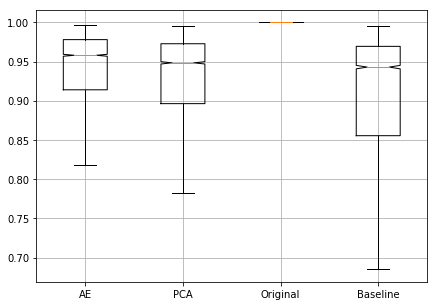

In [92]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca, 'Original': electrode_data_test, "Baseline": comp_pca(0)}
find_correlation_coeff(d)

PCA 0.1032211296776236
AE 0.08859065092895355
Baseline 0.2516964198919793


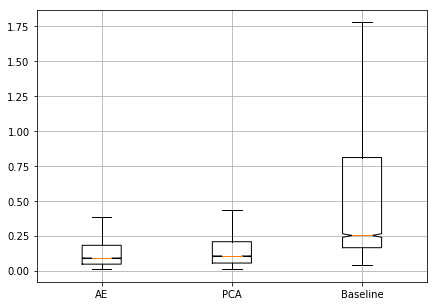

In [99]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse, 'Baseline': baseline})

In [94]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [100]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

AE 0.9580237766693592
PCA 0.948394974723551
Baseline 0.9429411251524722
[('AE', 0.9580237766693592), ('PCA', 0.948394974723551), ('Baseline', 0.9429411251524722)]
Baseline Value:  0.9429411251524722
AE Value:  0.9580237766693592
PCA Value:  0.948394974723551

 AE improvement:  1.5995326870962587
PCA improvement:  0.5783870727026549


In [101]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

Baseline Value:  0.2516964198919793
AE Value:  0.08859065092895355
PCA Value:  0.1032211296776236

 AE improvement:  64.80257805535173
PCA improvement:  58.98983000158561
